In [11]:
import torch
import torch.nn as nn
from torch.nn.utils.parametrizations import weight_norm



class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [12]:
def smape(actual, predicted):
    # actual和predicted维度相同且为numpy数组
    numerator = np.abs(predicted - actual)
    denominator = (np.abs(actual) + np.abs(predicted)) / 2.0
    # 避免除0操作，如果分母出现0可以适当加一个极小值或者只对非零项进行计算
    # 不过理论上如果actual和predicted都为0，误差也为0，可以跳过。
    # 这里简单处理下，如果分母为0则该项SMAPE为0。
    valid_mask = (denominator != 0)
    smape_val = 100.0 * np.mean((numerator[valid_mask] / denominator[valid_mask]))
    return smape_val


Sales matrix shape: (46, 34)
Train data shape: (46, 26)
Val data shape: (46, 4)
Test data shape: (46, 4)
Train sequences shape: (11, 46, 12)
Train targets shape: (11, 46, 4)
Val history shape: (46, 16)
Val sequences shape: (1, 46, 12)
Val targets shape: (1, 46, 4)
Test history shape: (46, 8)
Test sequences before reshape: (46, 8)
Test sequences after reshape: (1, 46, 8)
Gradient max abs value: 3.002913899763371e-06
Gradient max abs value: 1.2419498034432763e-06
Gradient max abs value: 2.78368452200084e-06
Gradient max abs value: 8.339759006048553e-06
Gradient max abs value: 2.0363597741379635e-06
Gradient max abs value: 4.668508154281881e-06
Gradient max abs value: 7.472298875654815e-06
Gradient max abs value: 1.2107934708183166e-05
Gradient max abs value: 1.870206688181497e-05
Gradient max abs value: 5.266979314910714e-06
Gradient max abs value: 7.350719897658564e-06
Gradient max abs value: 3.49342699337285e-05
Gradient max abs value: 4.951972641720204e-06
Gradient max abs value: 9.24

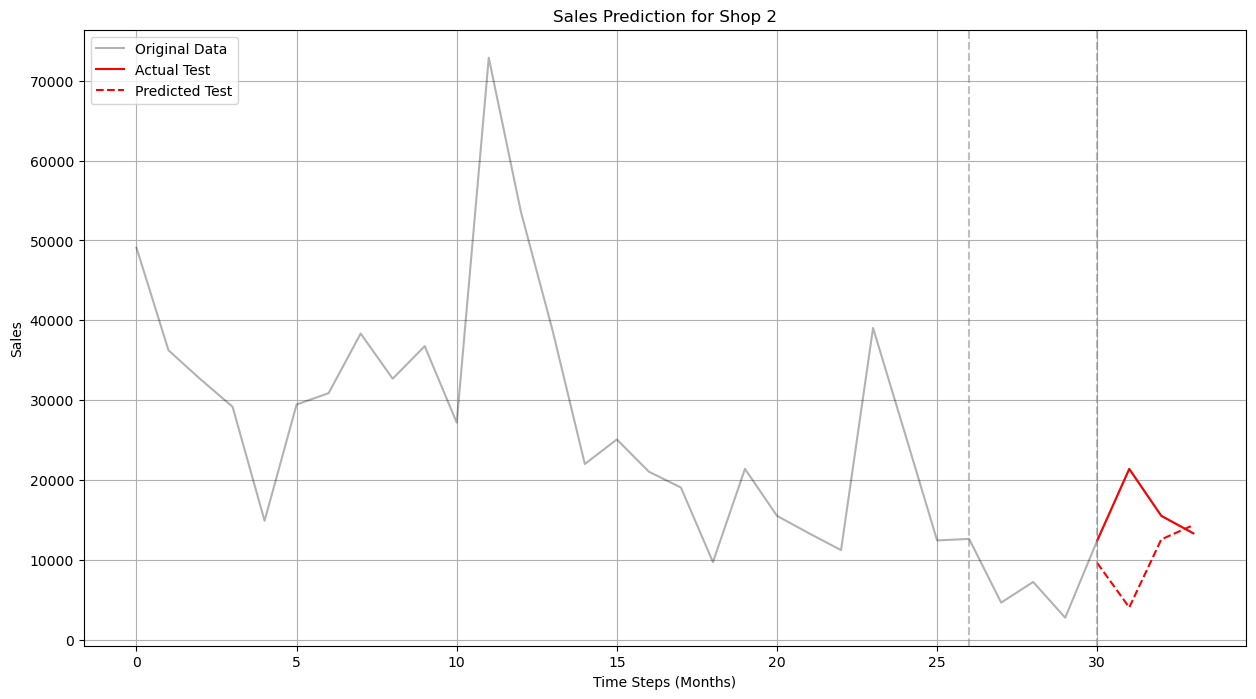


Shop 3:
MSE: 24514820.93
MAE: 3200.30


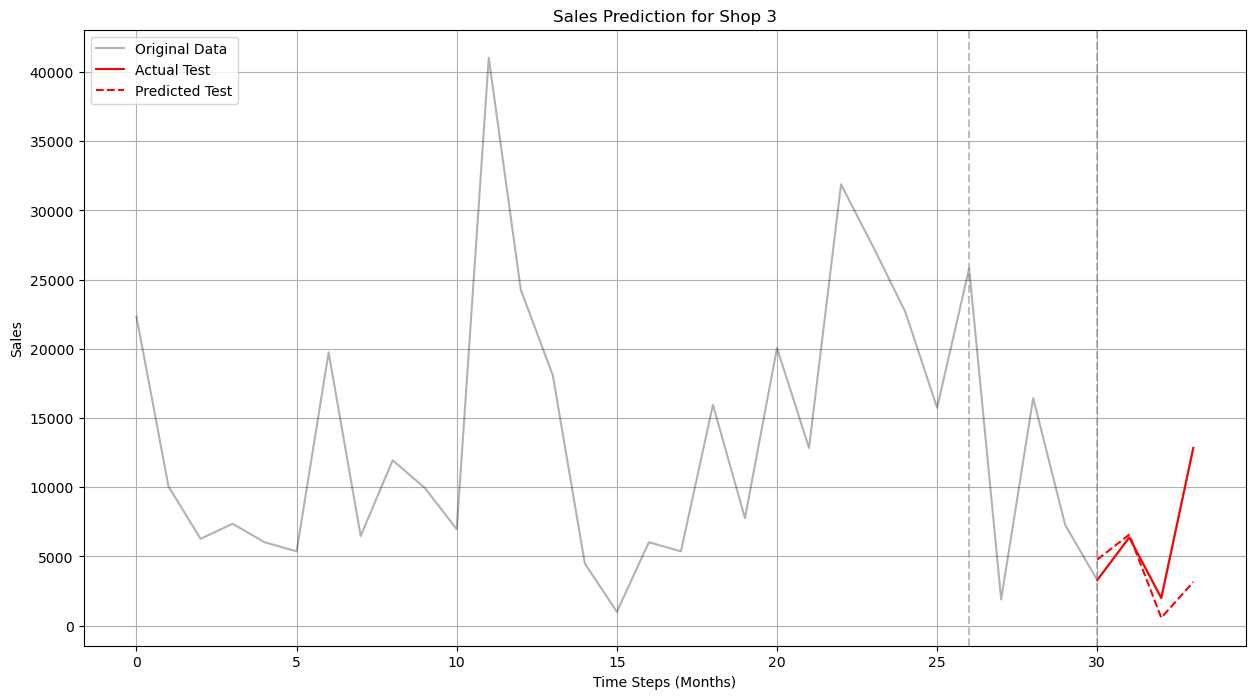


Shop 4:
MSE: 17843016.82
MAE: 3894.70


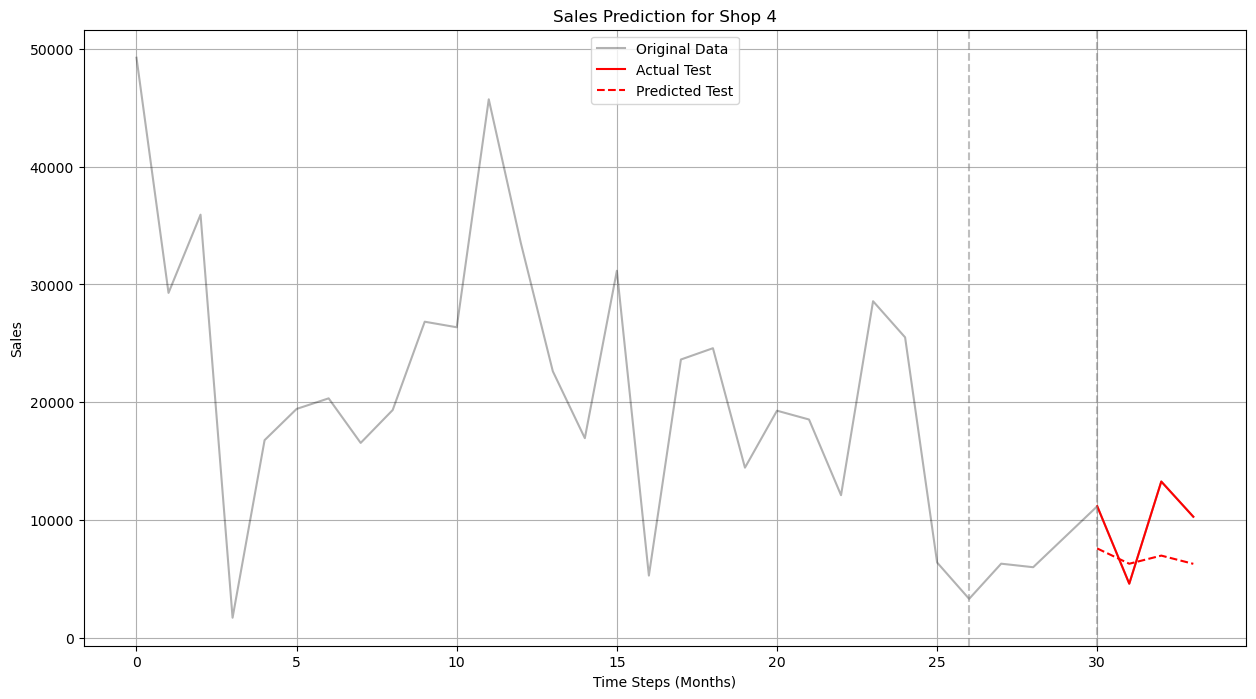


Shop 5:
MSE: 27659444.78
MAE: 4600.47


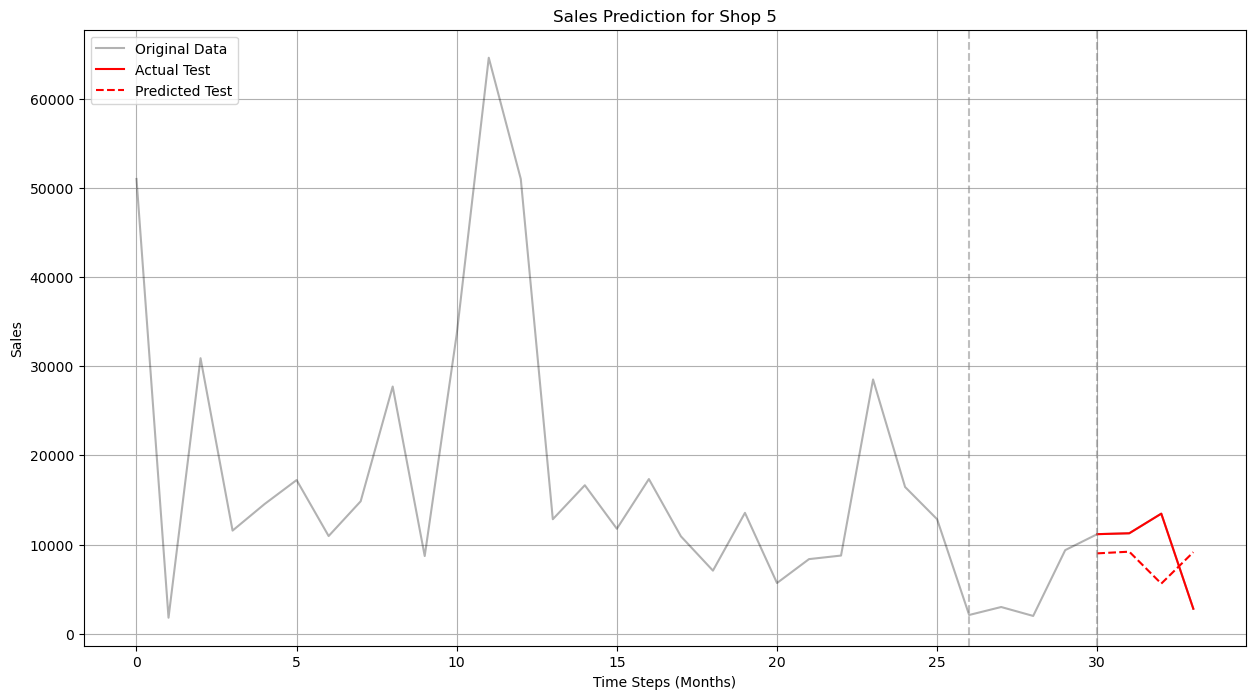


Shop 6:
MSE: 50700513.60
MAE: 6568.05


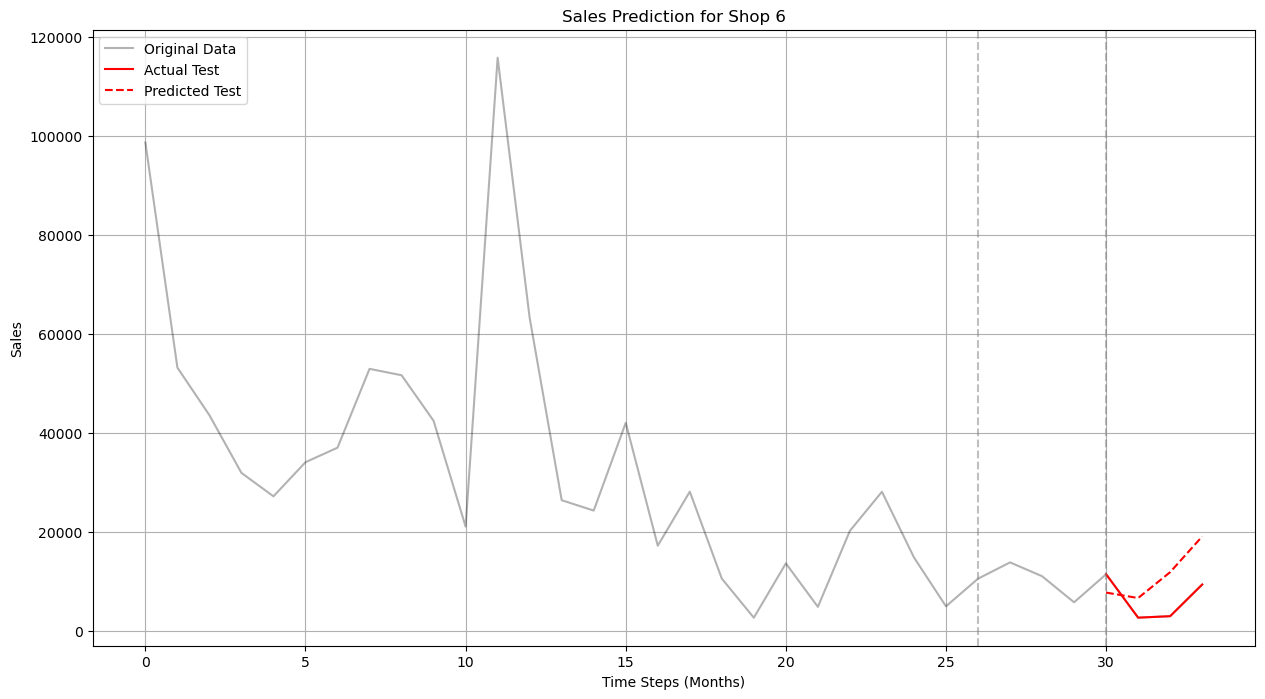


Shop 7:
MSE: 163639469.11
MAE: 10273.93


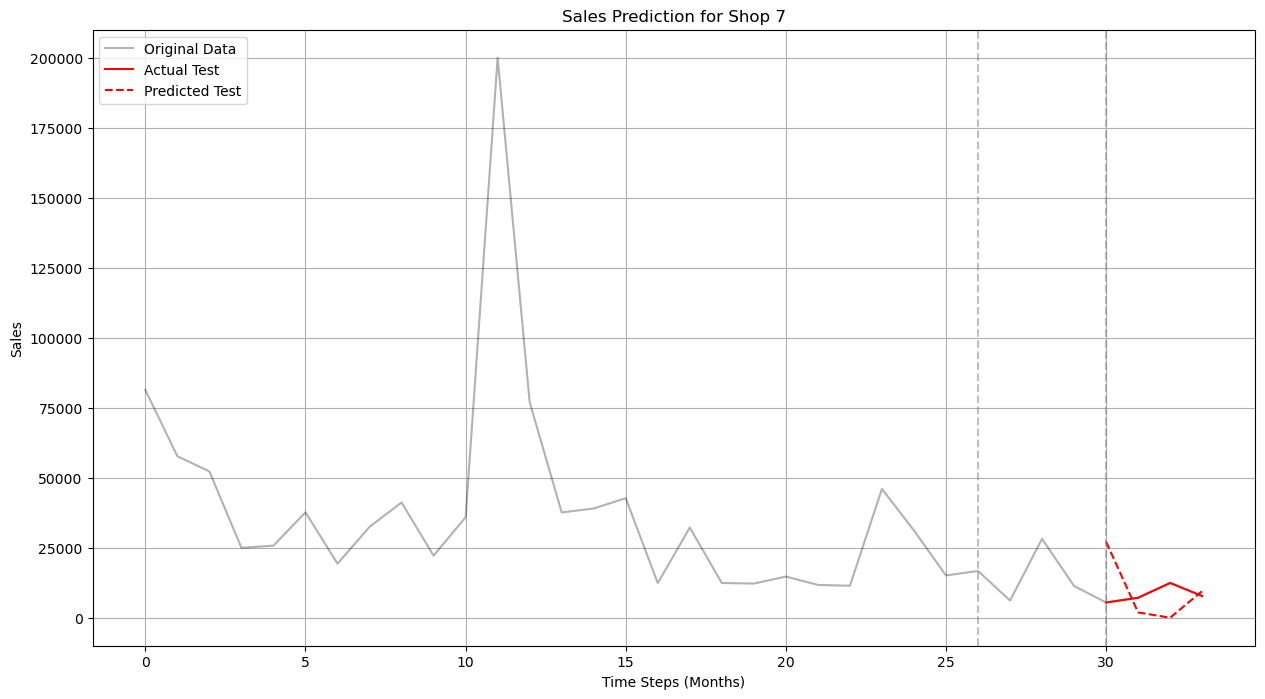


Shop 10:
MSE: 6129794.83
MAE: 2143.09


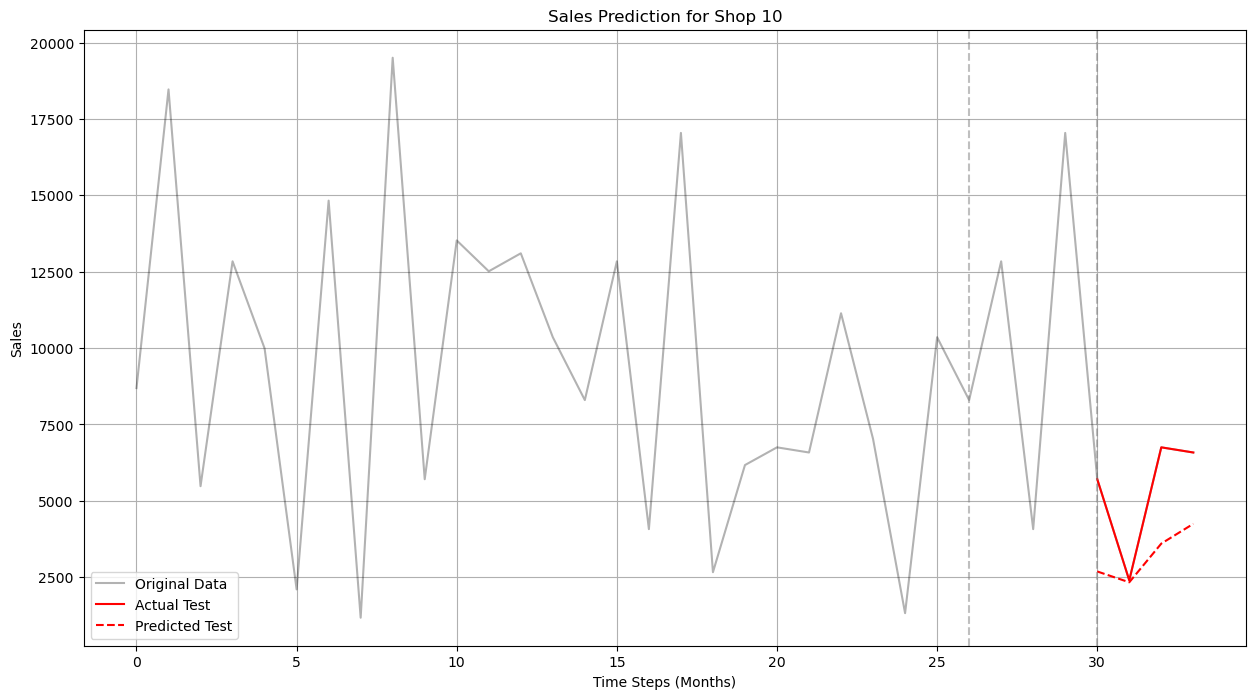


Shop 12:
MSE: 40425636.72
MAE: 4802.16


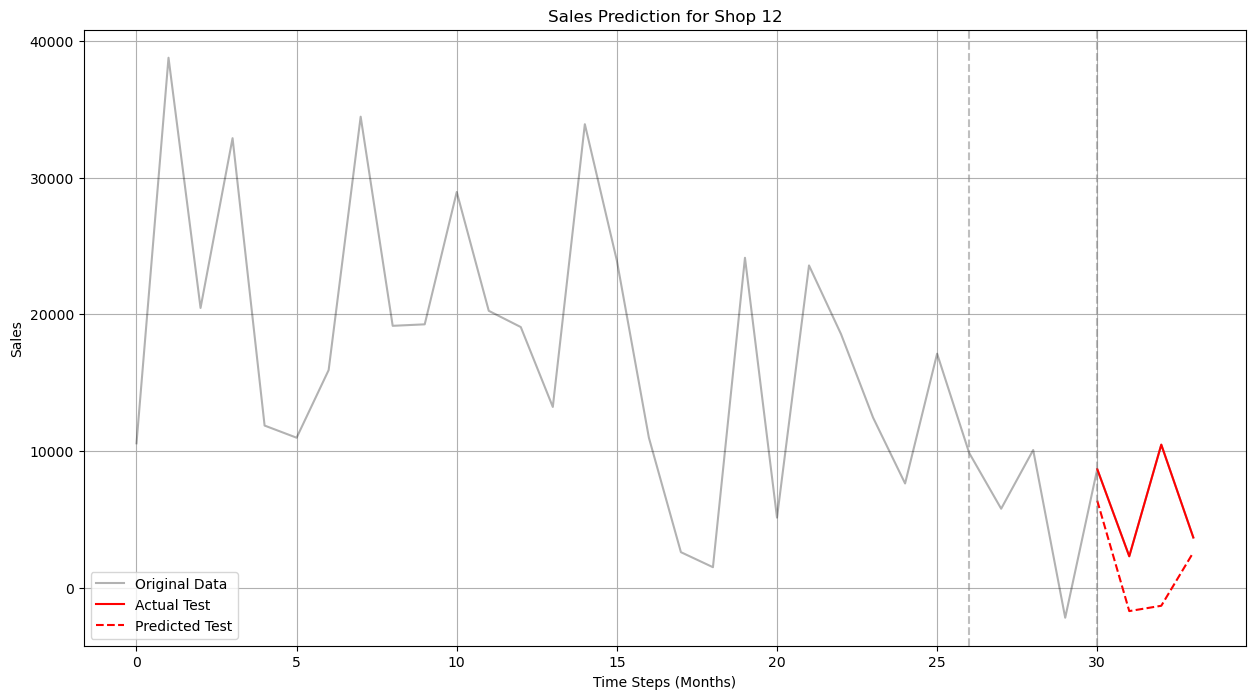


Shop 14:
MSE: 147718682.64
MAE: 11104.14


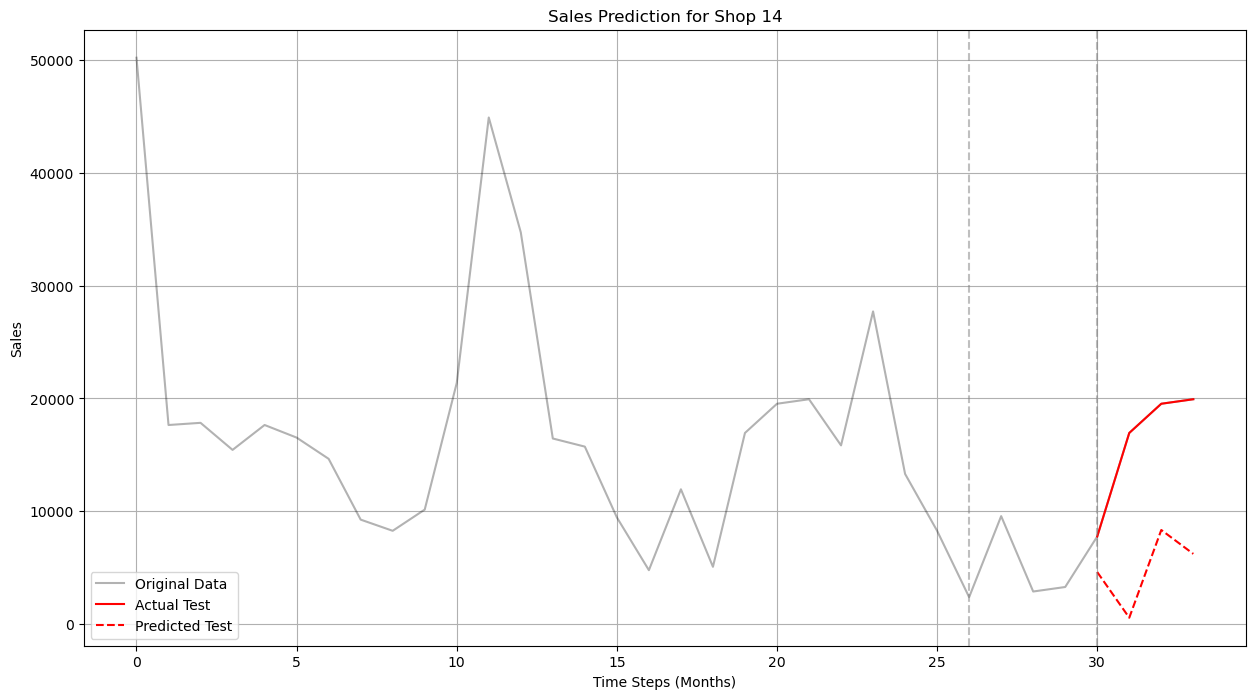


Shop 15:
MSE: 11129857.39
MAE: 2739.84


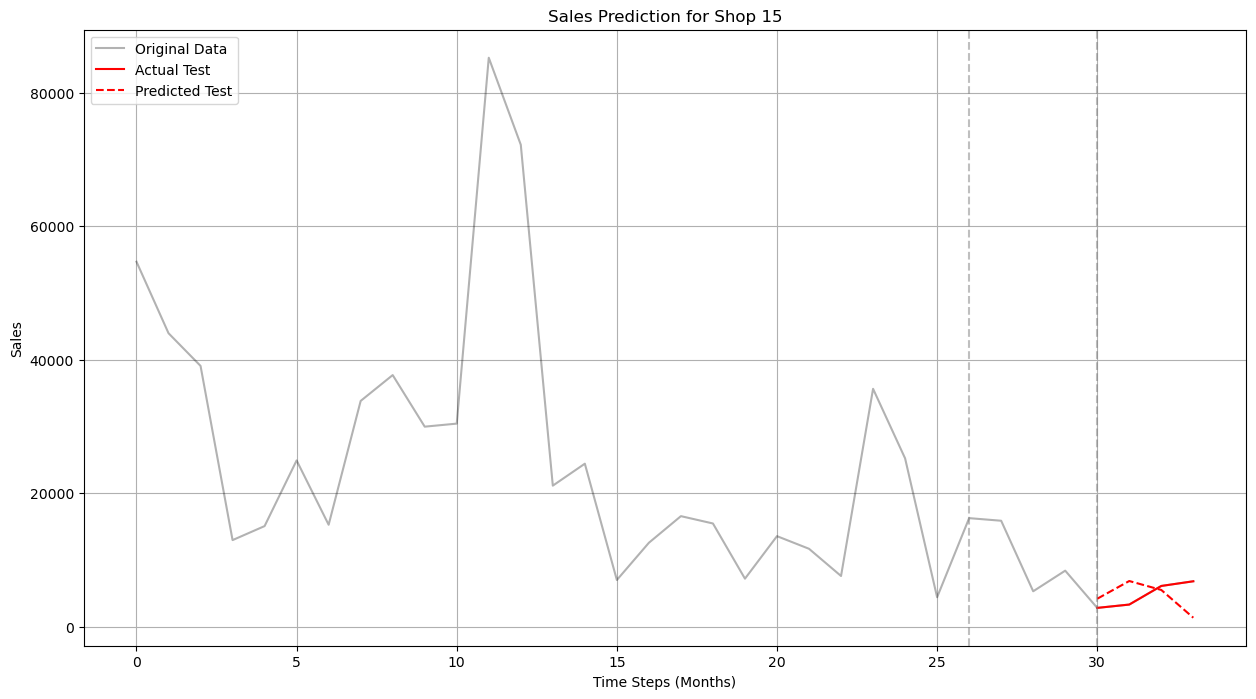


Shop 16:
MSE: 26794696.41
MAE: 4216.20


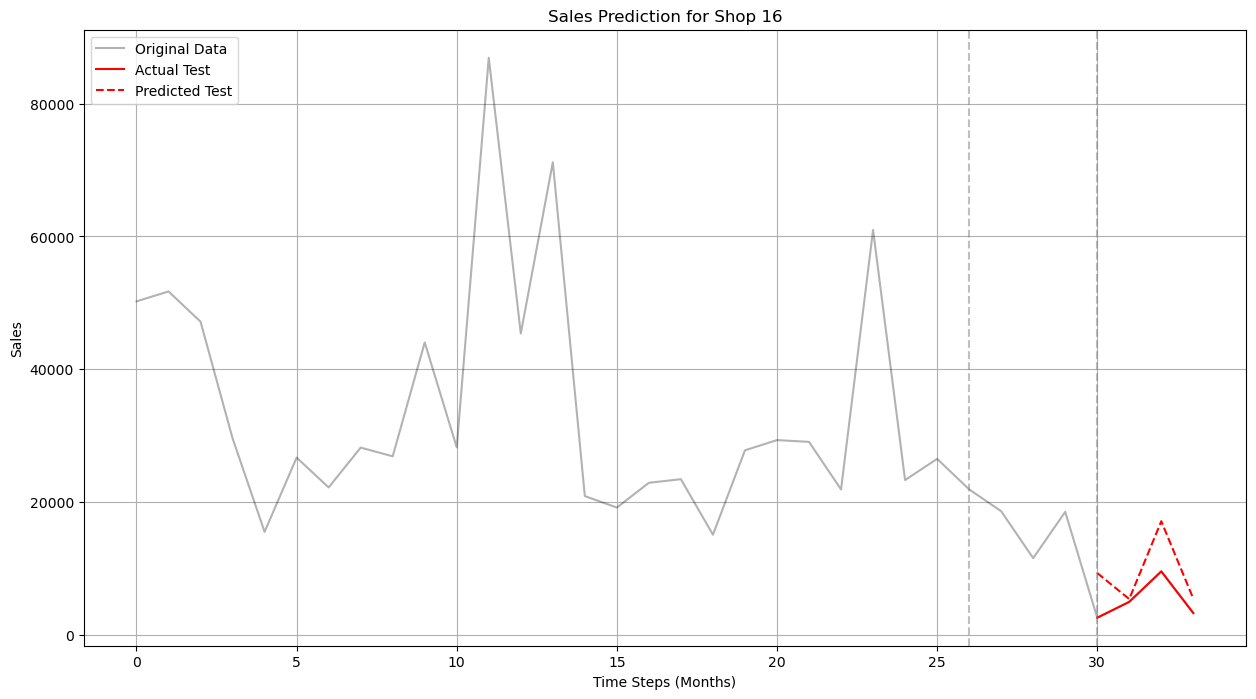


Shop 17:
MSE: 15546617.61
MAE: 3227.89


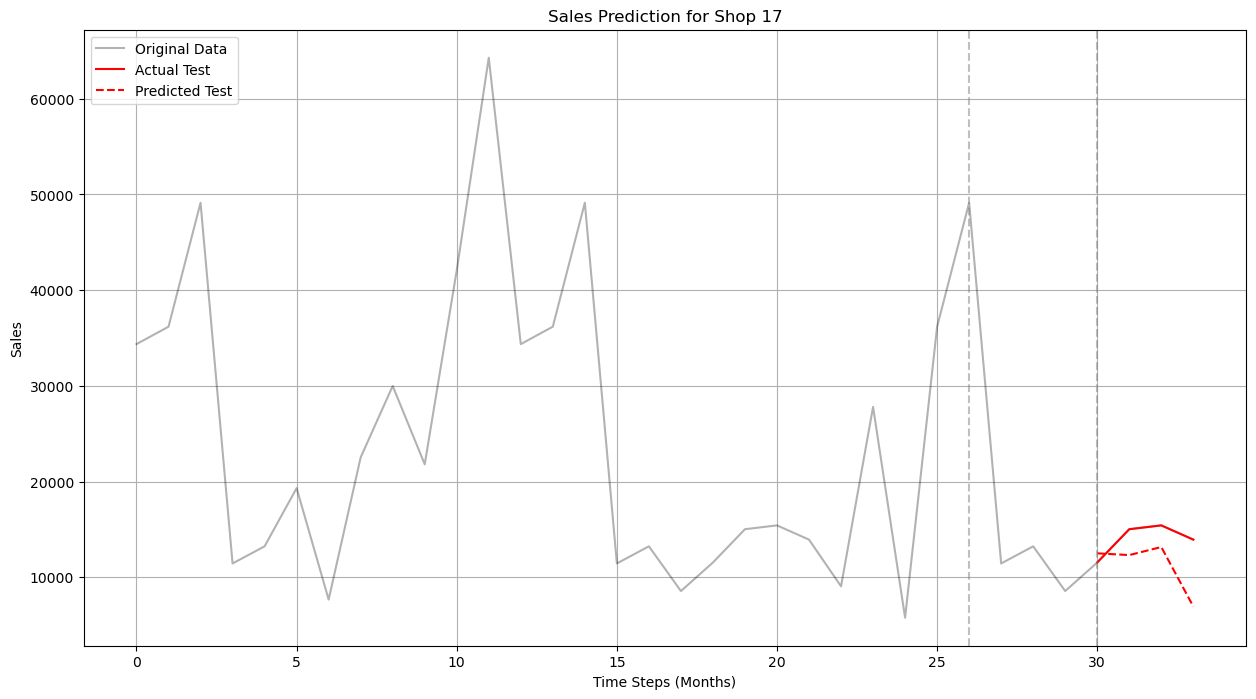


Shop 18:
MSE: 505172159.85
MAE: 18363.44


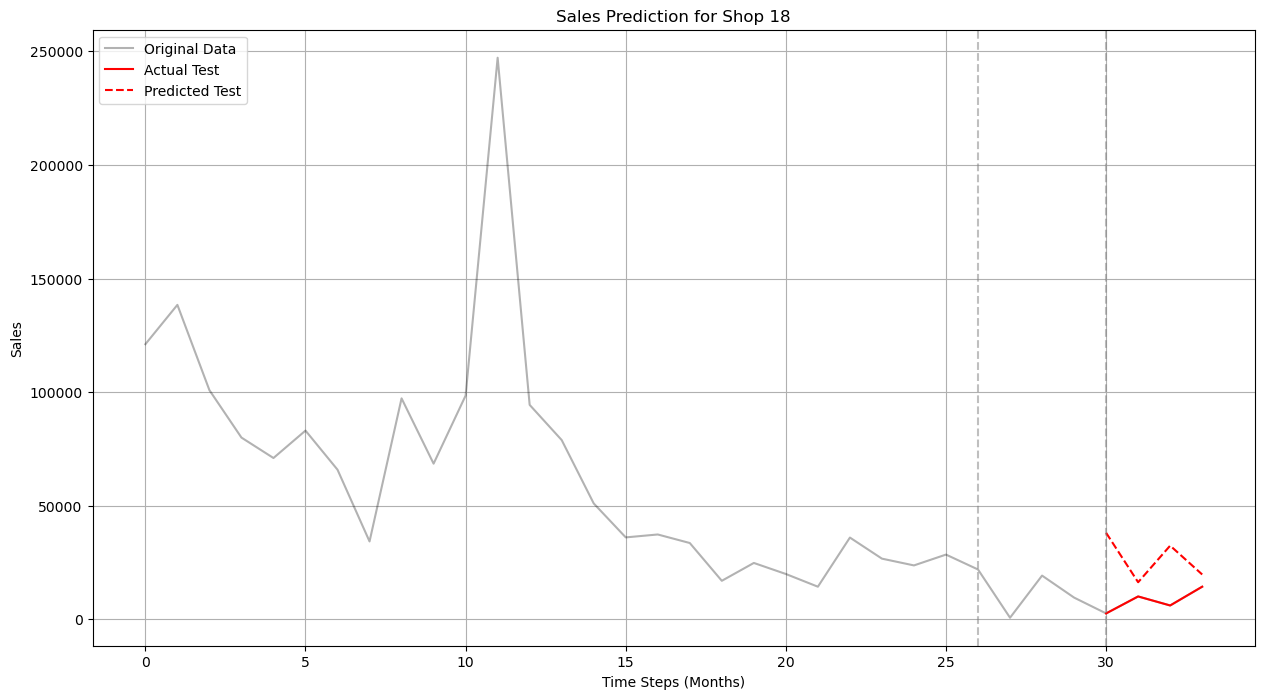


Shop 19:
MSE: 35137669.50
MAE: 5097.71


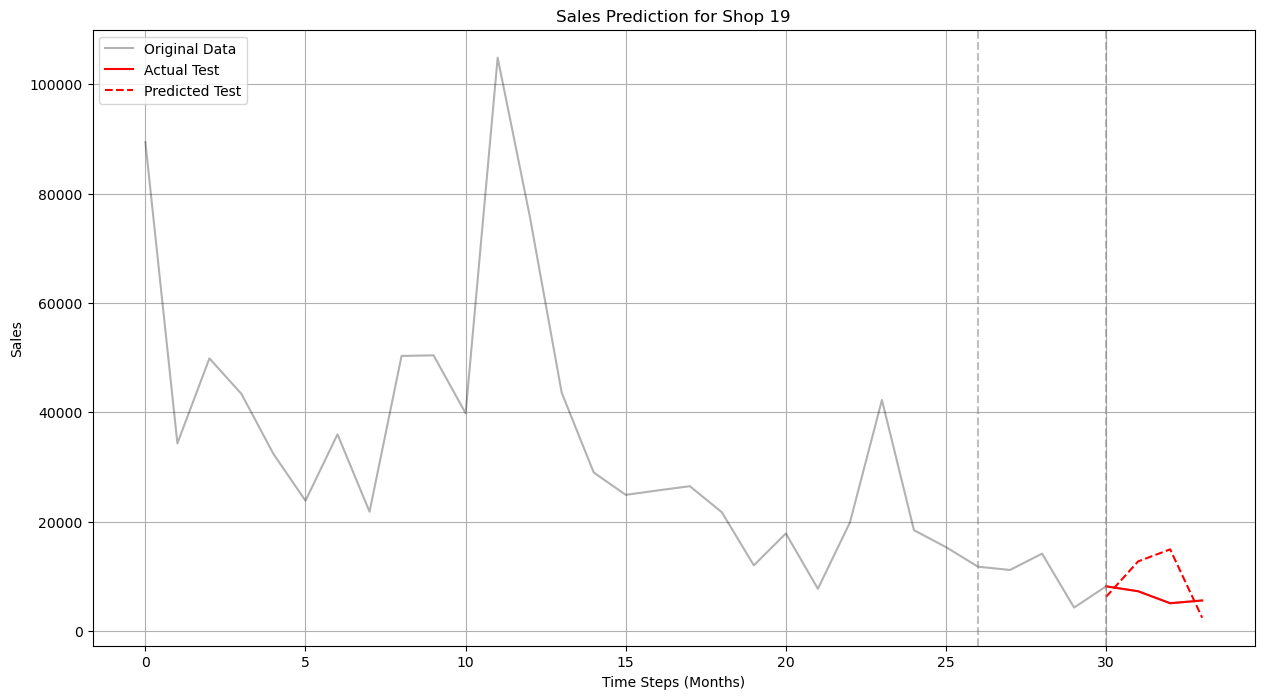


Shop 21:
MSE: 3039007.54
MAE: 1654.67


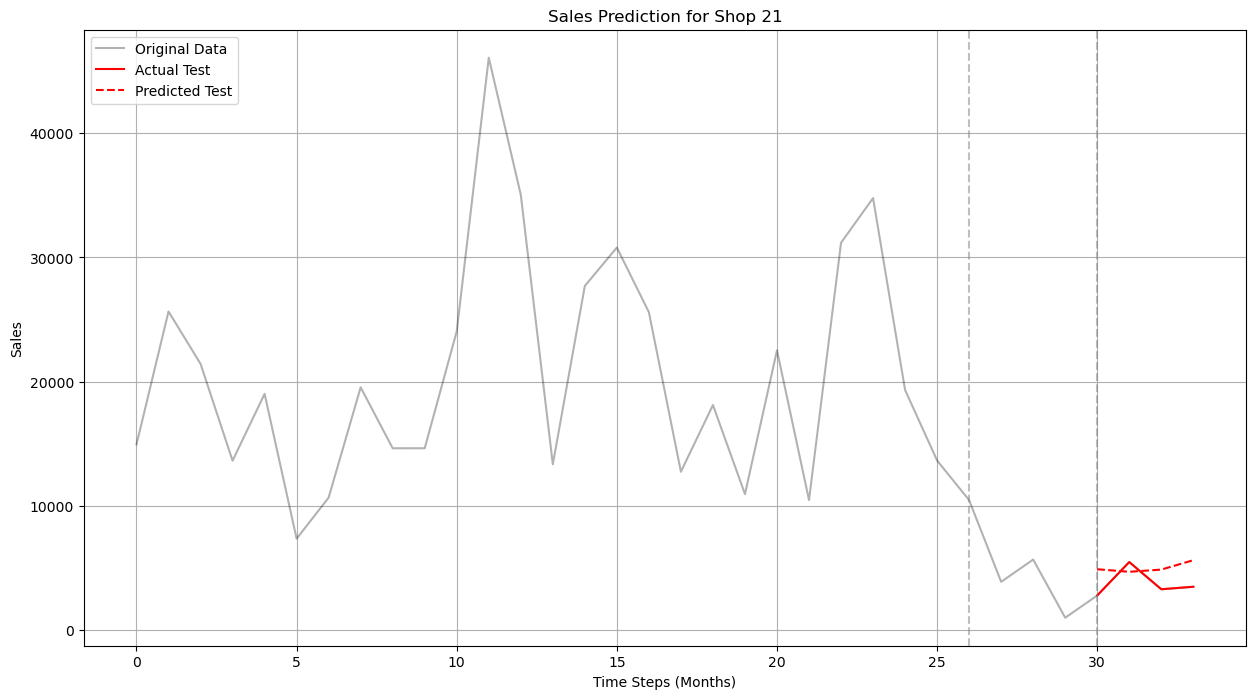


Shop 22:
MSE: 130152011.28
MAE: 10450.76


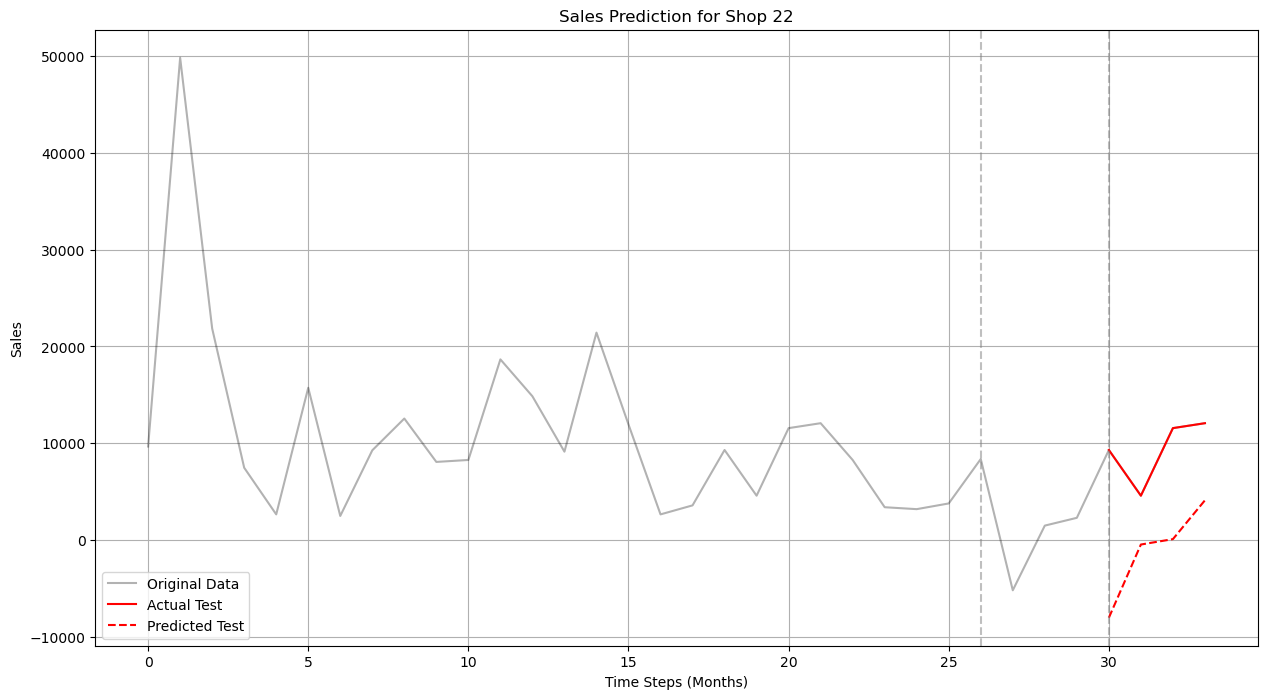


Shop 24:
MSE: 52581412.43
MAE: 5212.45


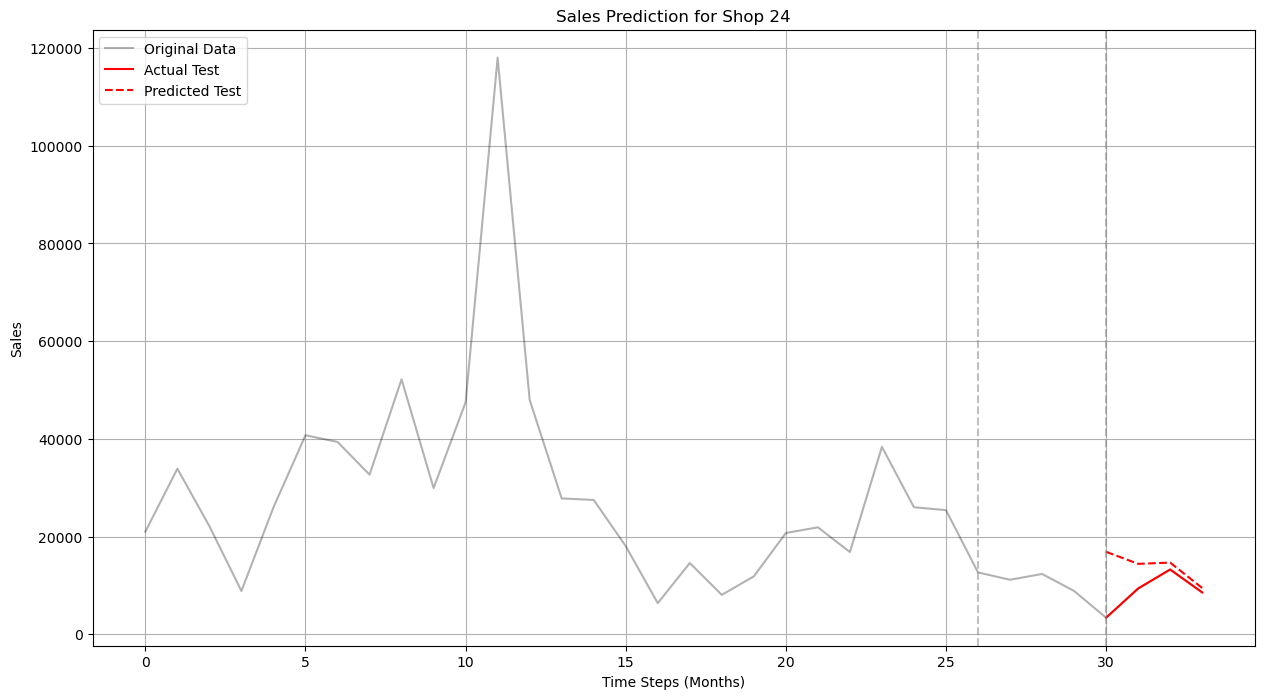


Shop 25:
MSE: 286712942.51
MAE: 14445.48


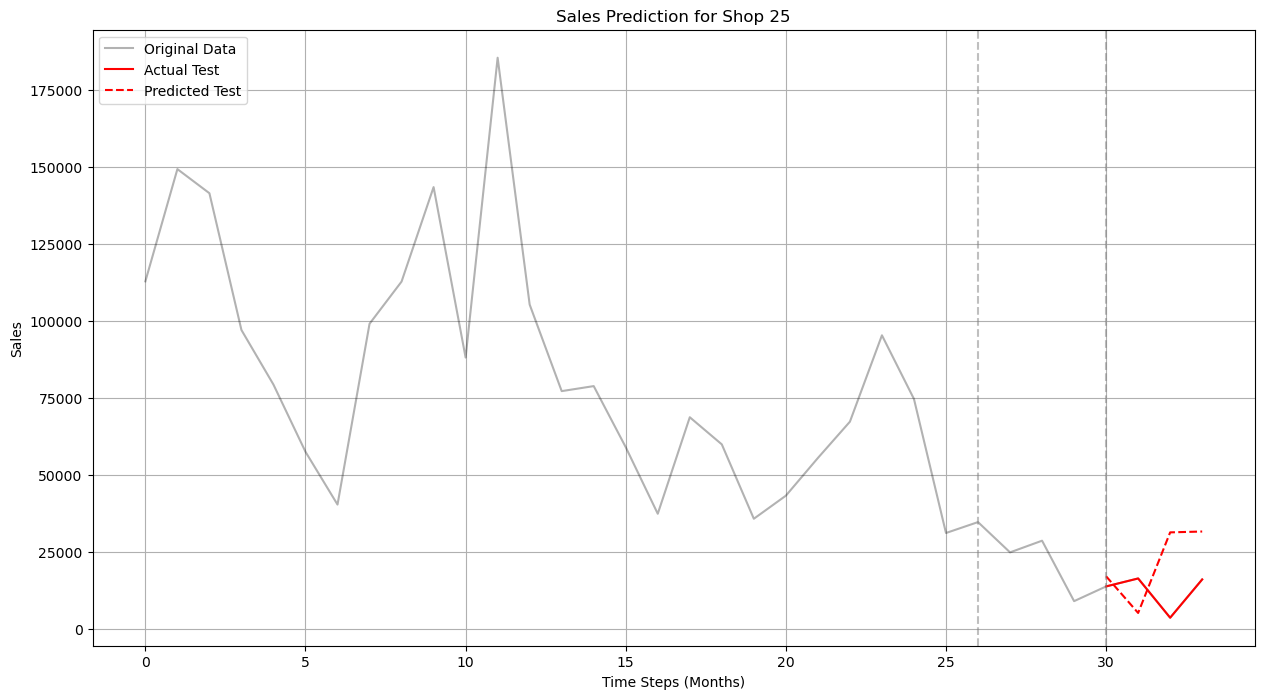


Shop 26:
MSE: 775873.54
MAE: 860.28


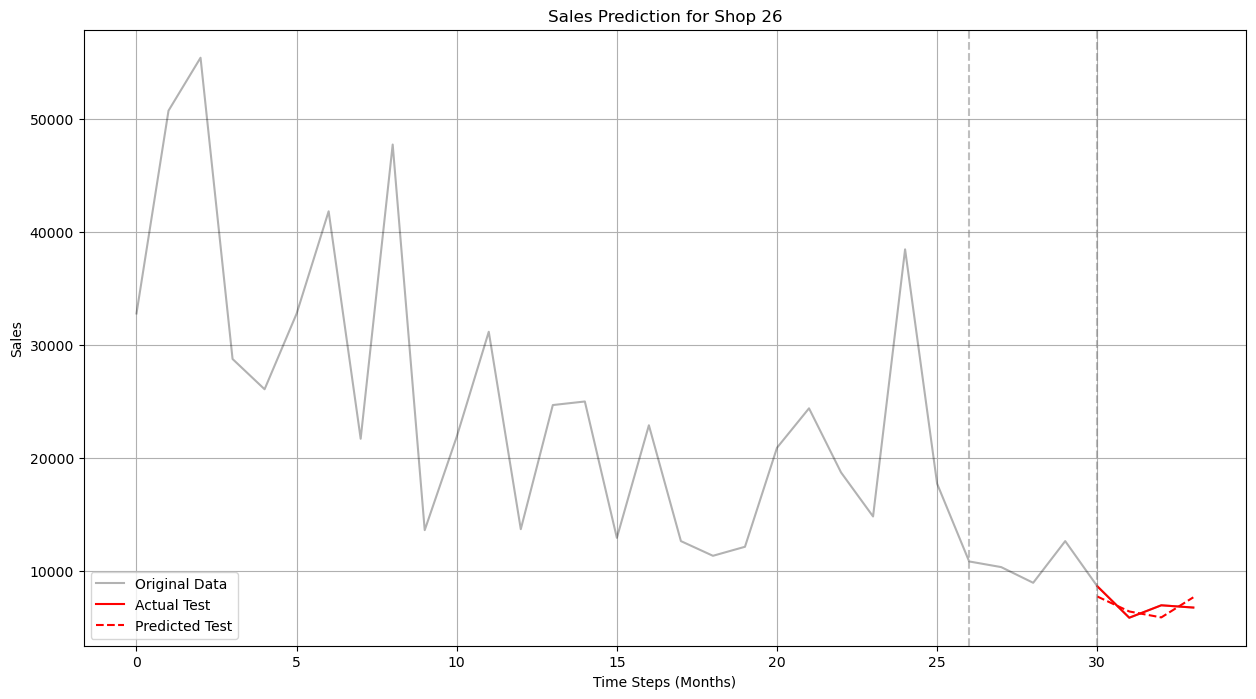


Shop 27:
MSE: 2012016539.30
MAE: 40378.99


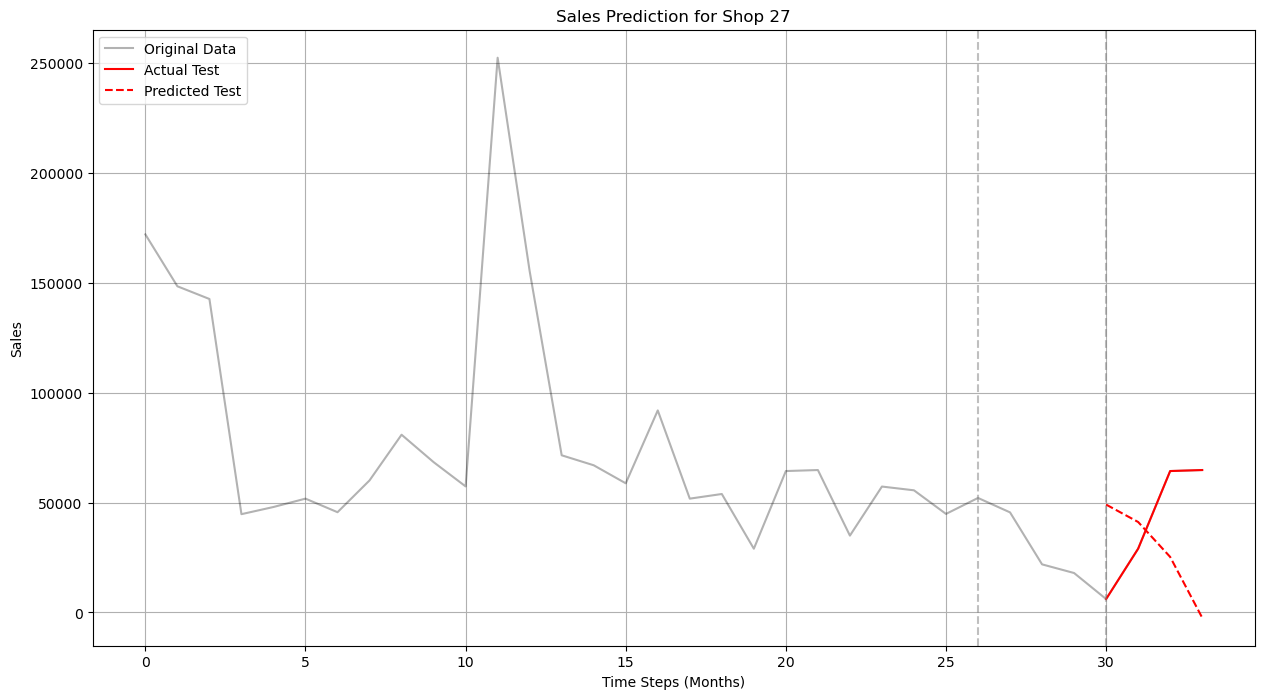


Shop 28:
MSE: 674626339.69
MAE: 19826.50


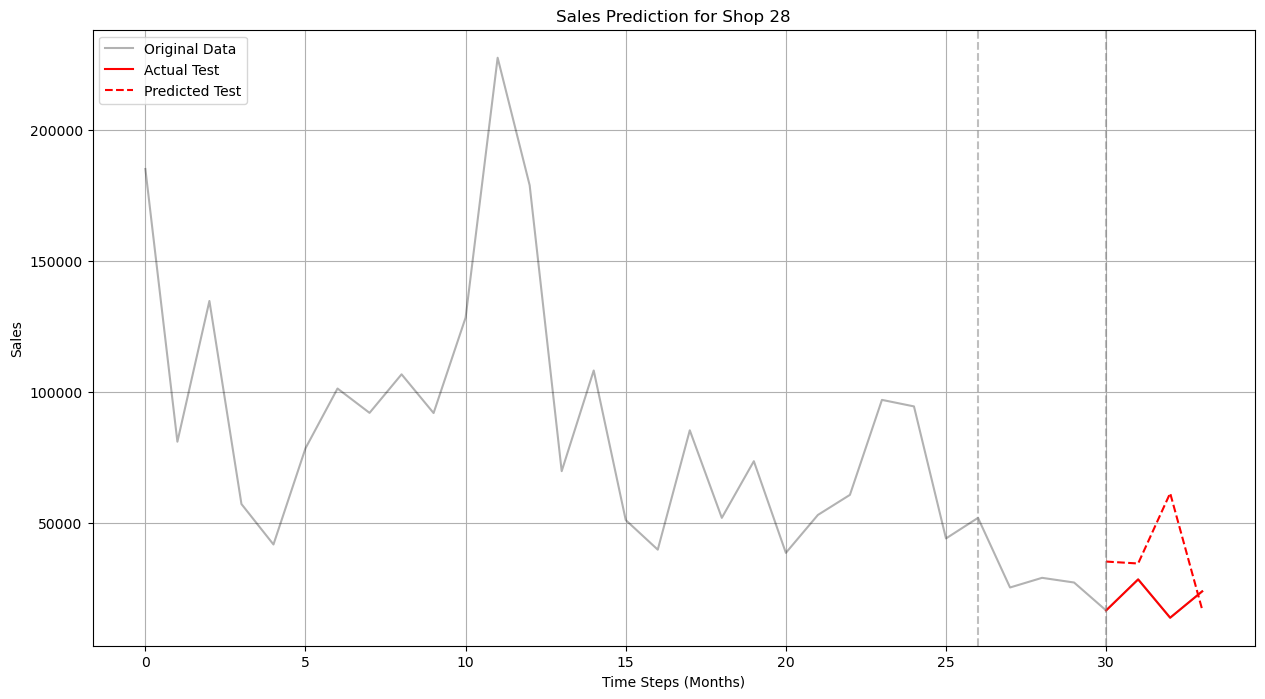


Shop 29:
MSE: 120556822.97
MAE: 9521.90


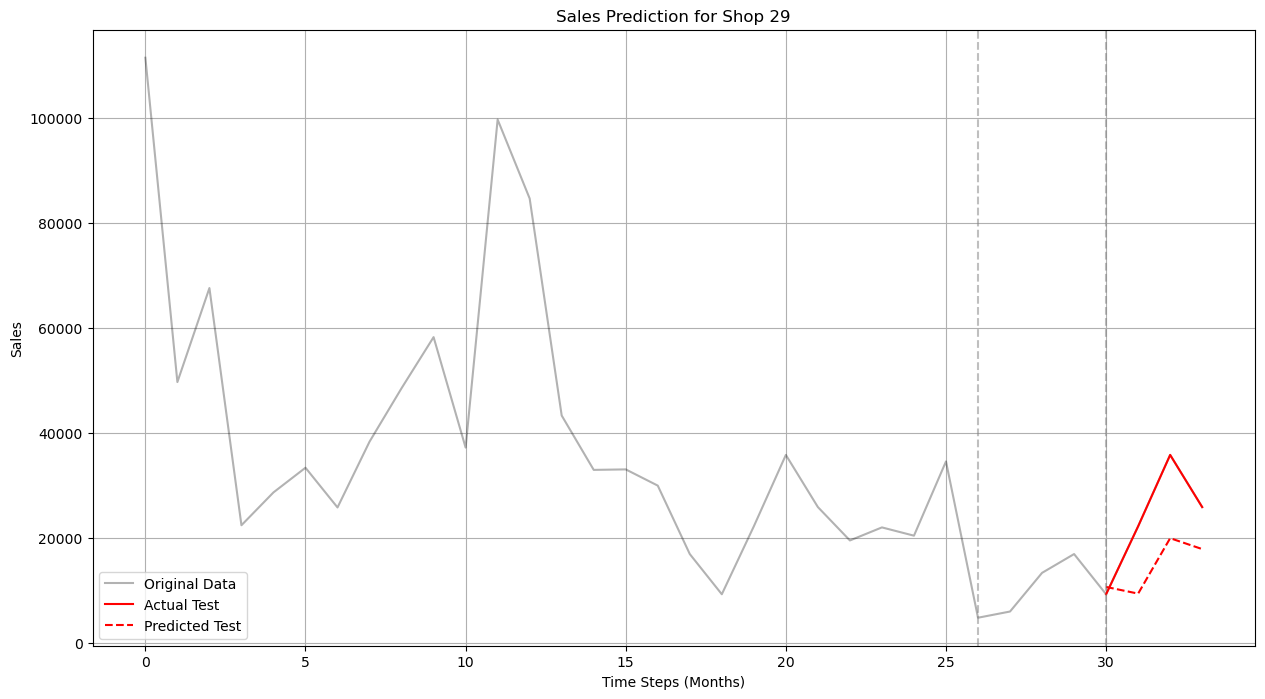


Shop 30:
MSE: 65201413.70
MAE: 6156.88


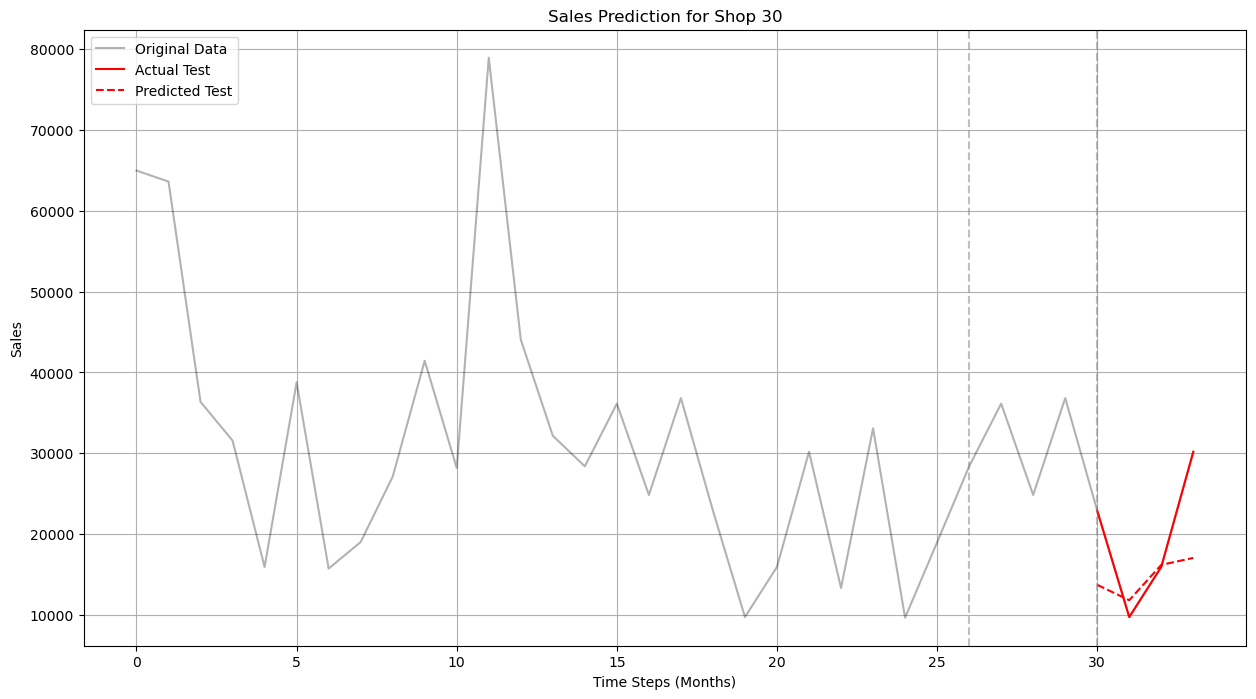


Shop 31:
MSE: 84080712.09
MAE: 8299.54


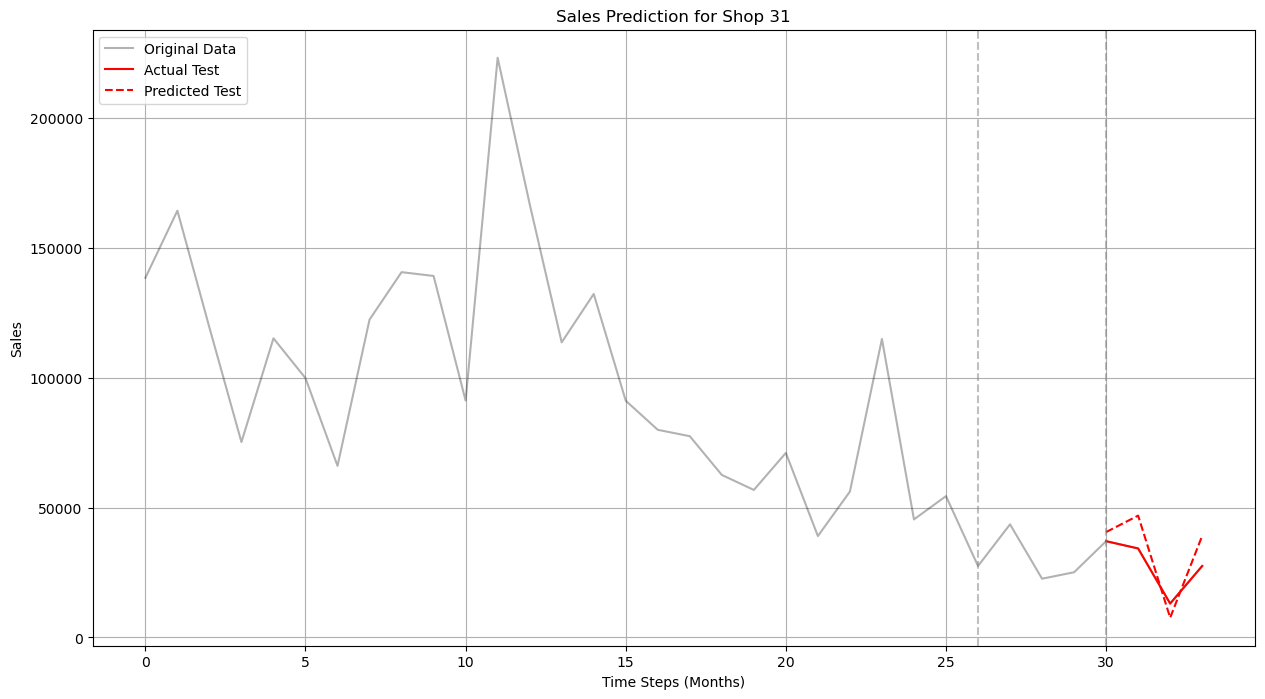


Shop 35:
MSE: 3812511.50
MAE: 1391.63


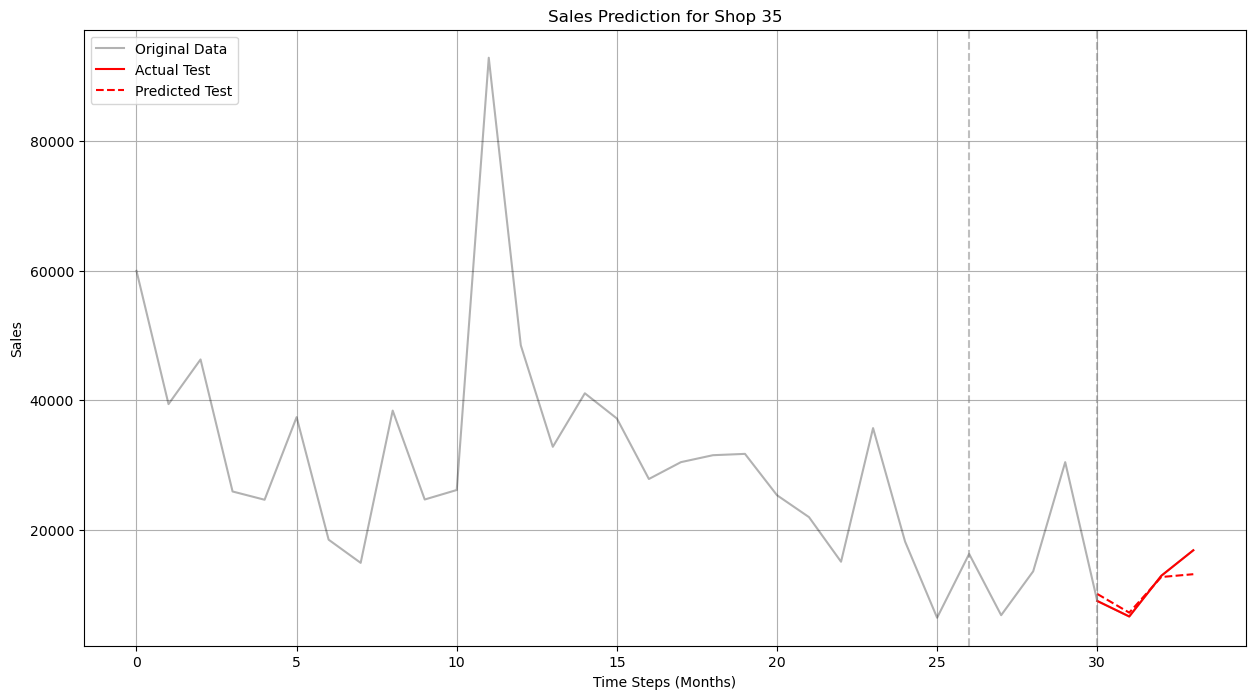


Shop 37:
MSE: 5556085.29
MAE: 1880.13


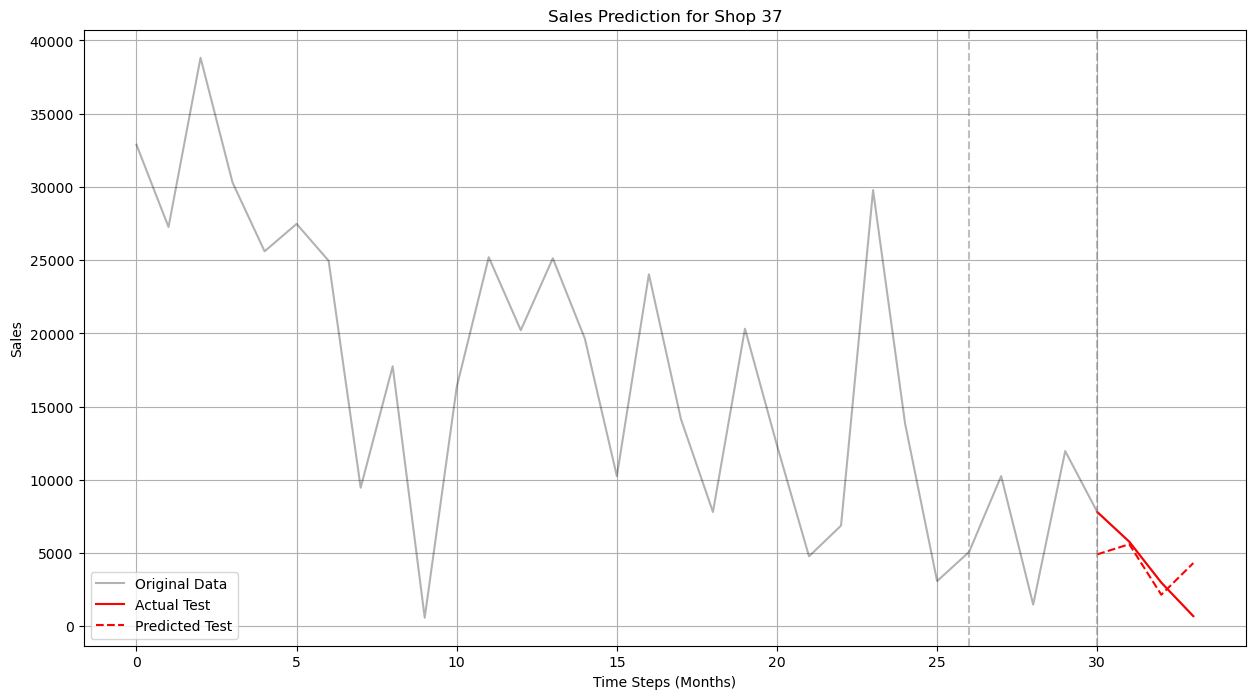


Shop 38:
MSE: 40653533.36
MAE: 4623.81


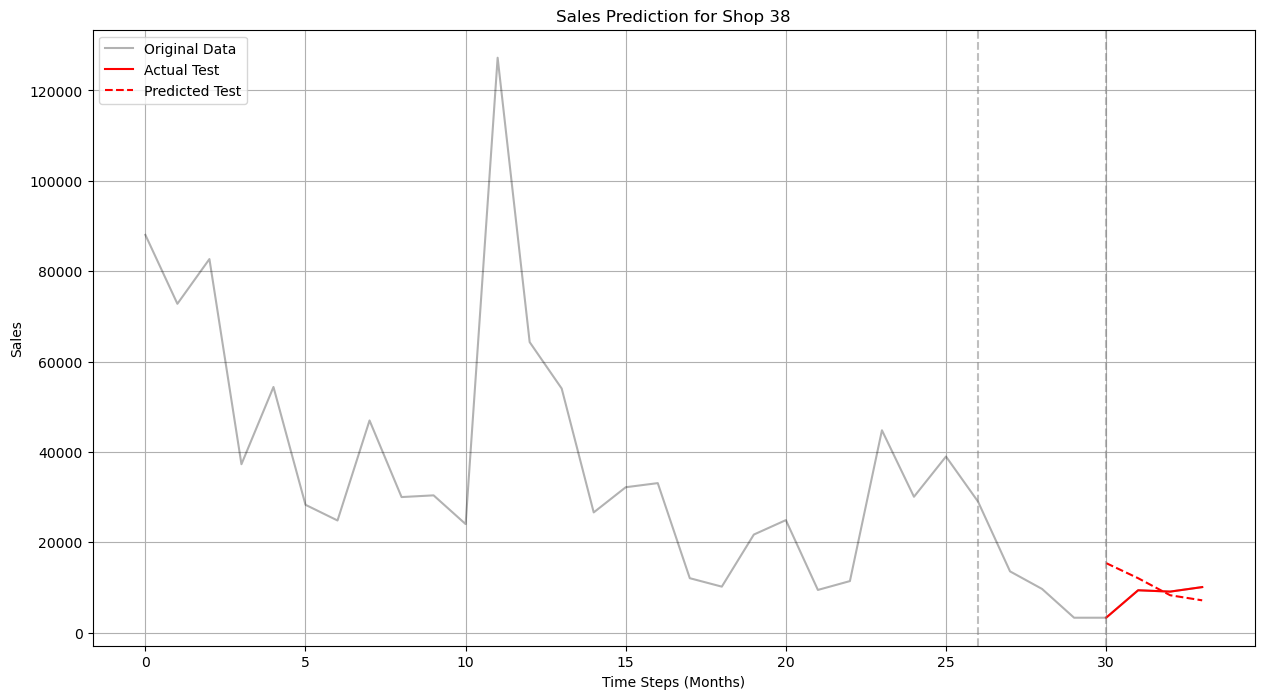


Shop 39:
MSE: 5556129.11
MAE: 2101.42


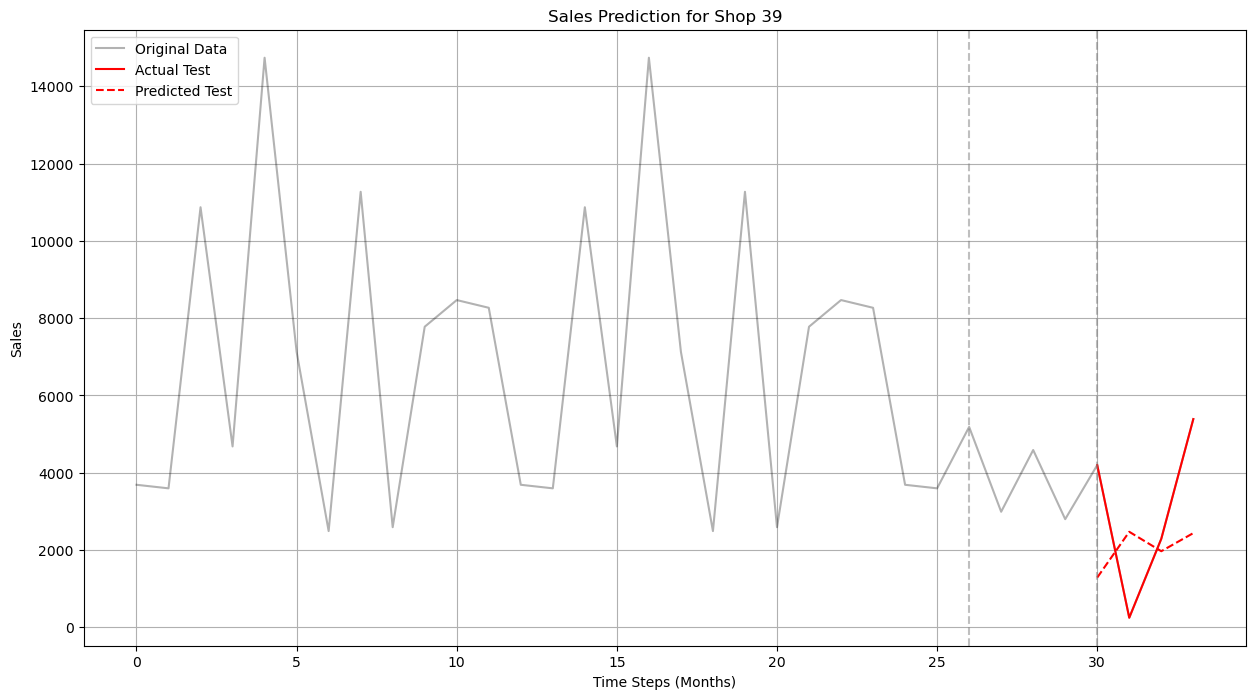


Shop 41:
MSE: 59873937.31
MAE: 6215.10


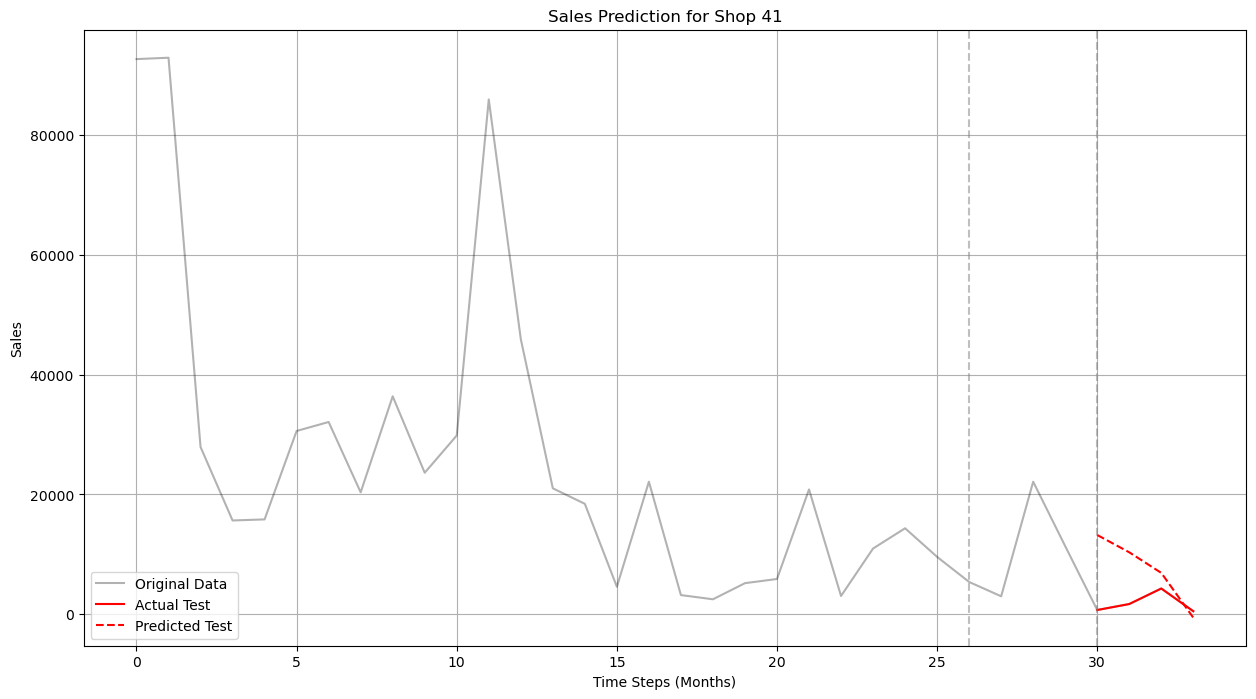


Shop 42:
MSE: 120798056.26
MAE: 7671.55


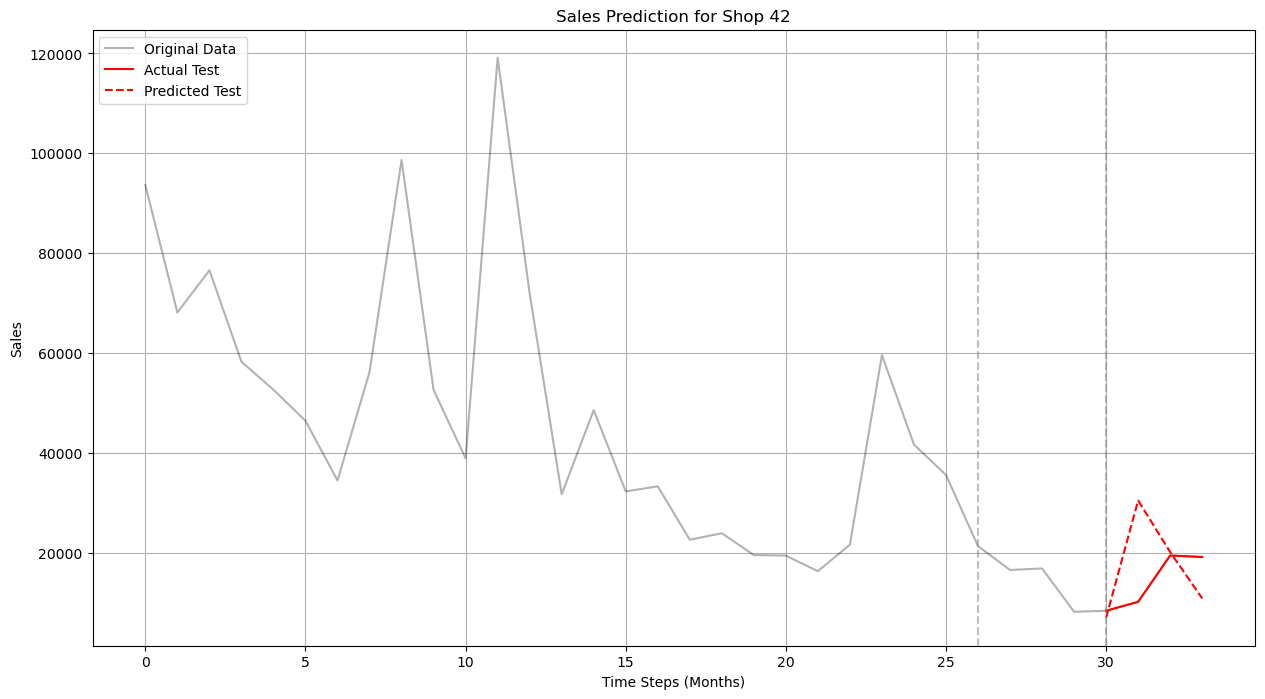


Shop 43:
MSE: 39579616.33
MAE: 4983.77


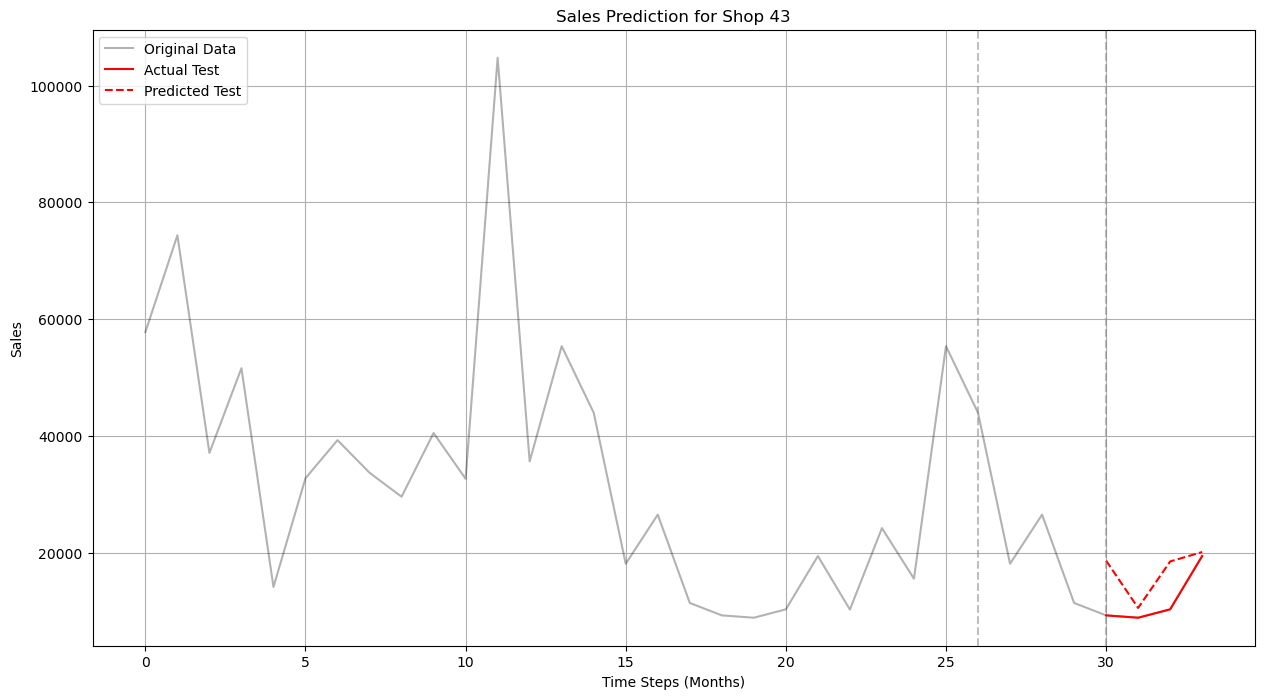


Shop 44:
MSE: 16693946.11
MAE: 3256.53


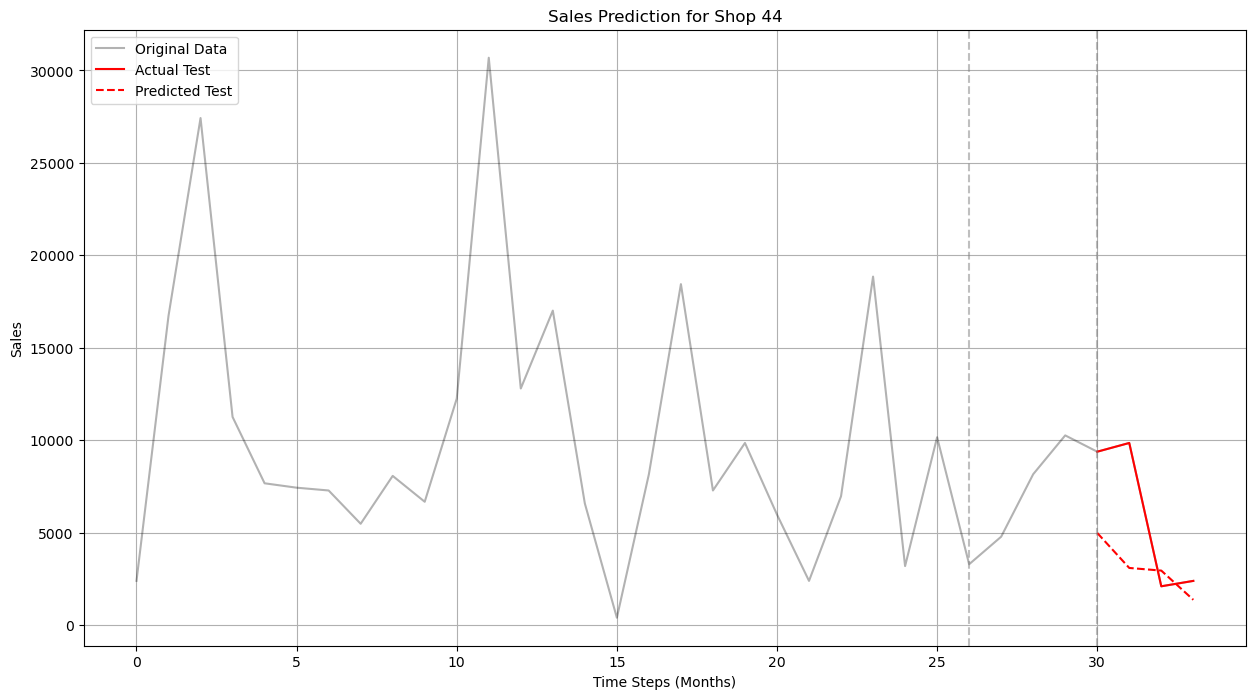


Shop 45:
MSE: 5508175.95
MAE: 2097.80


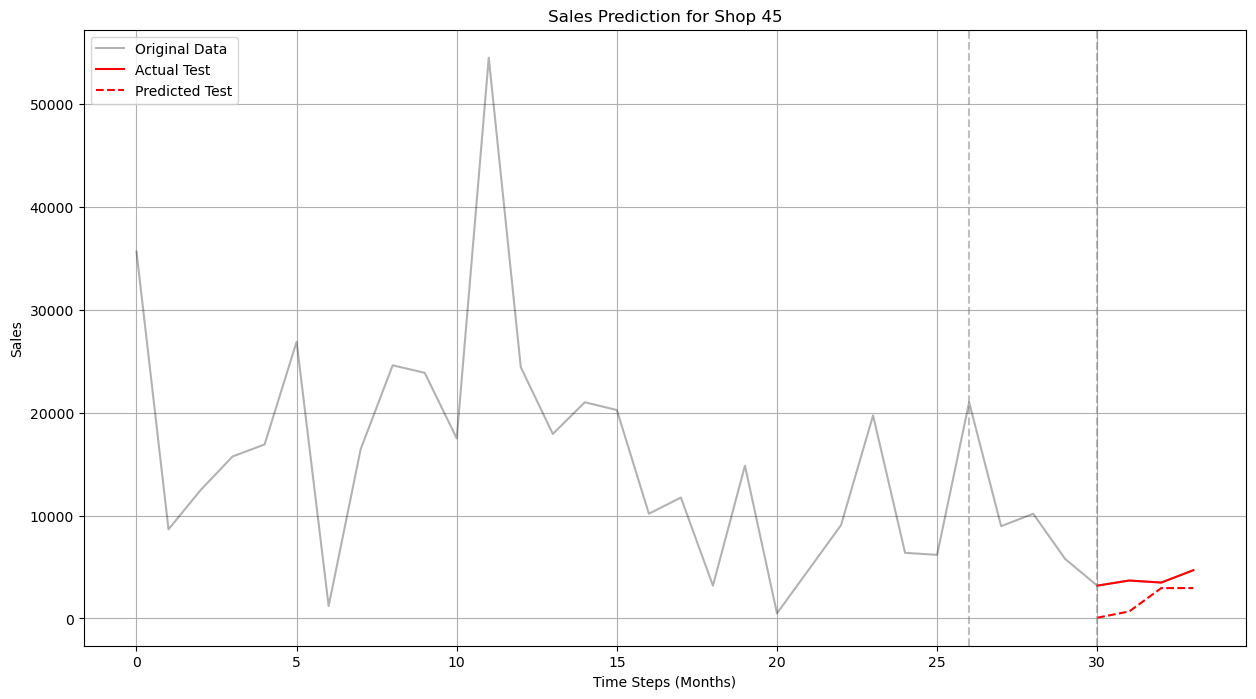


Shop 46:
MSE: 440389296.60
MAE: 18462.53


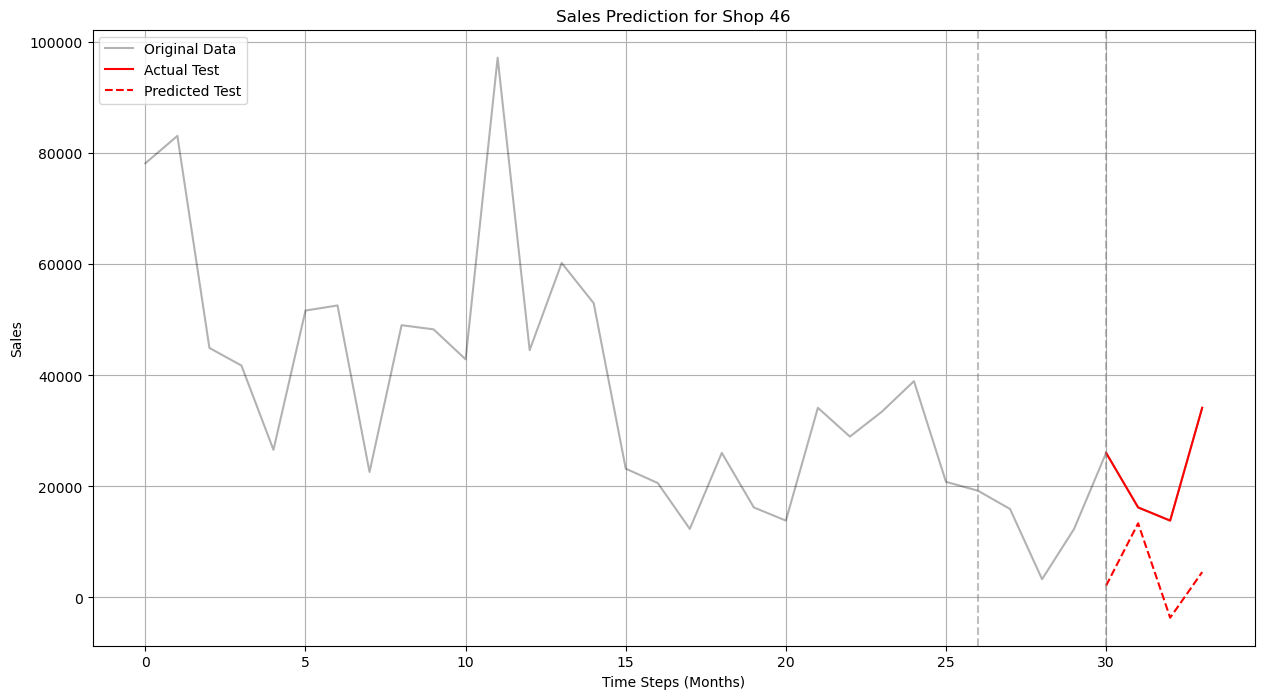


Shop 47:
MSE: 175465925.91
MAE: 8165.70


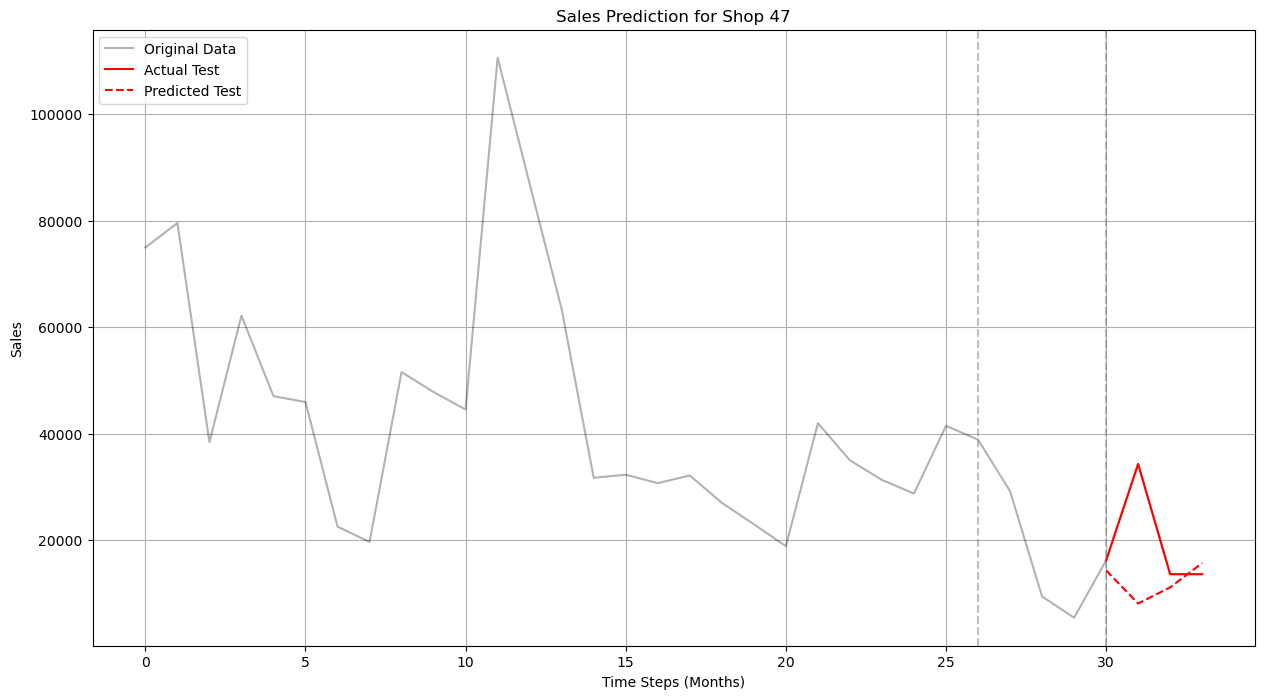


Shop 48:
MSE: 61646979.53
MAE: 7417.91


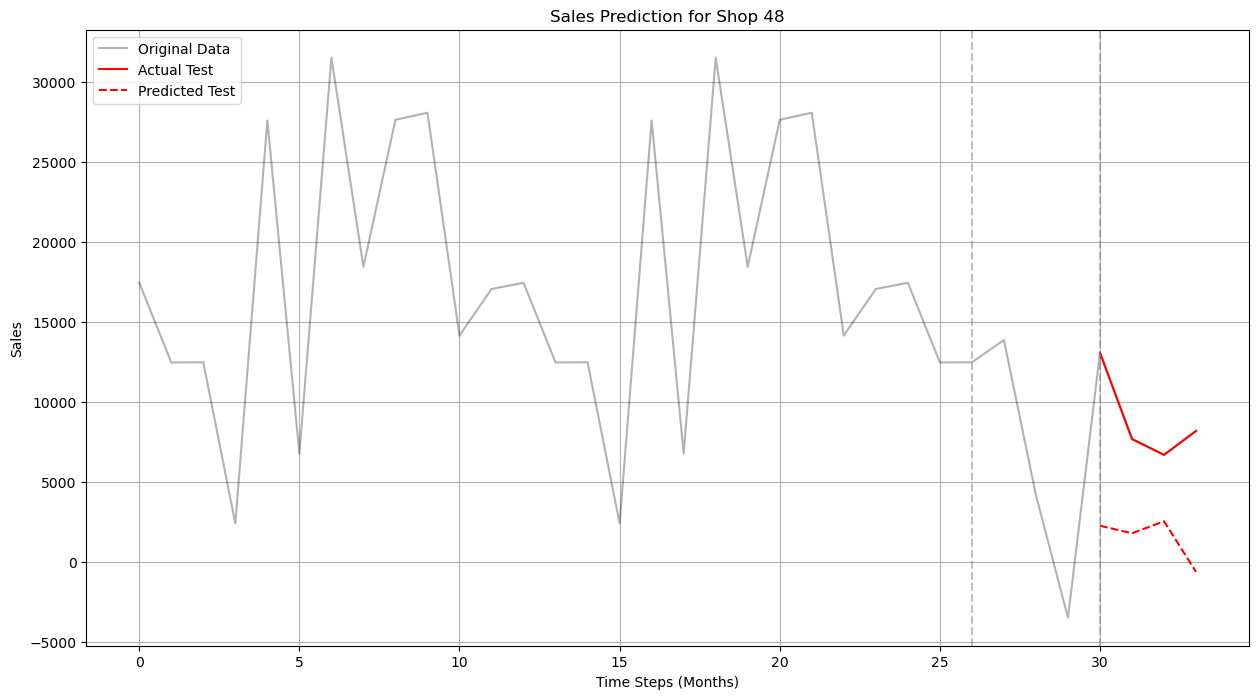


Shop 49:
MSE: 9243703.01
MAE: 2769.01


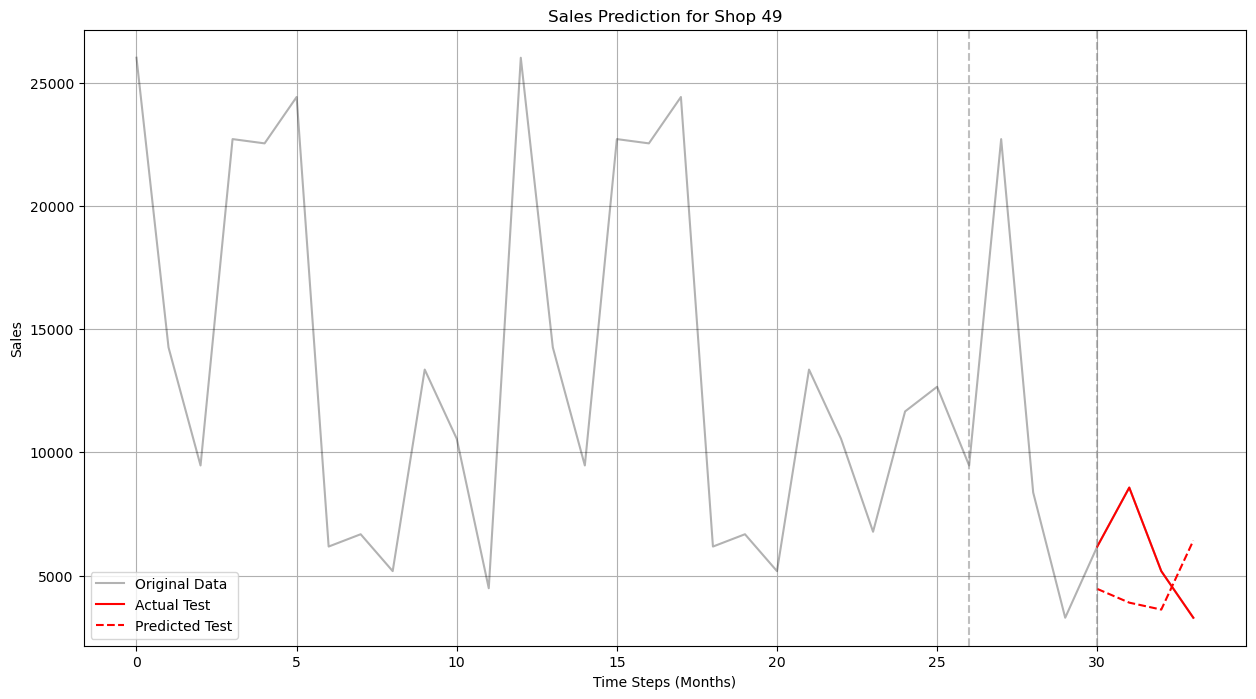


Shop 50:
MSE: 90154808.45
MAE: 8092.67


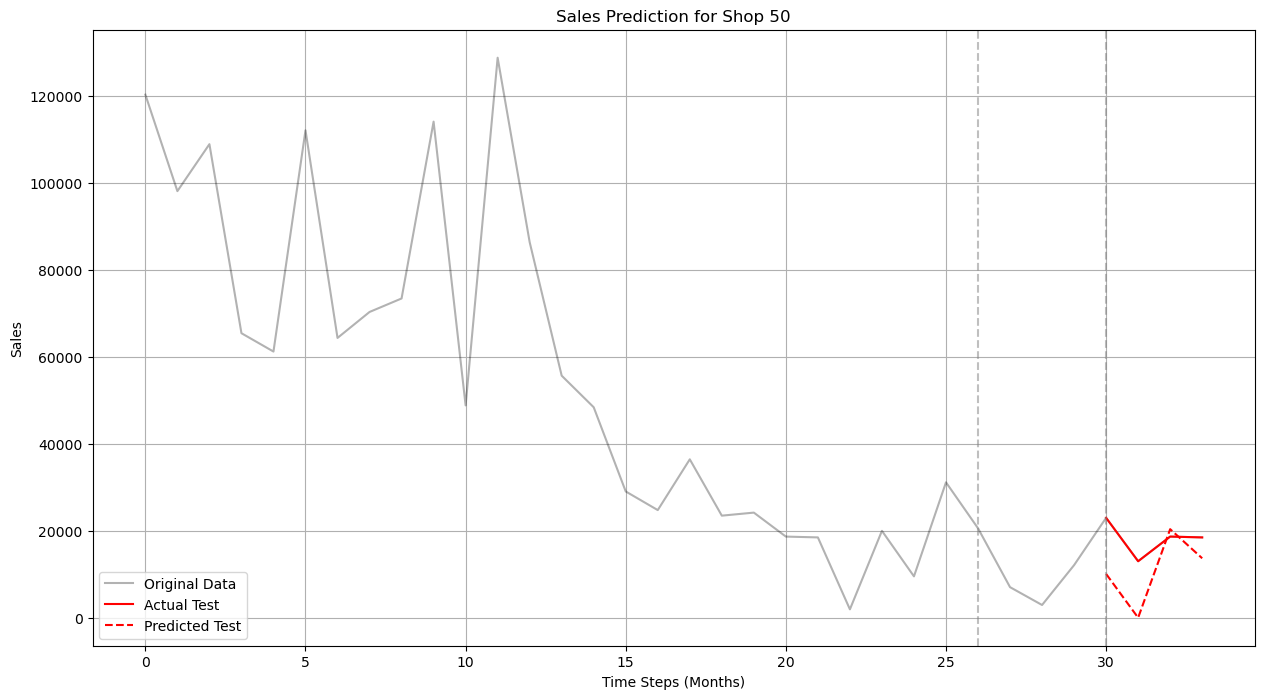


Shop 51:
MSE: 10272927.32
MAE: 2076.27


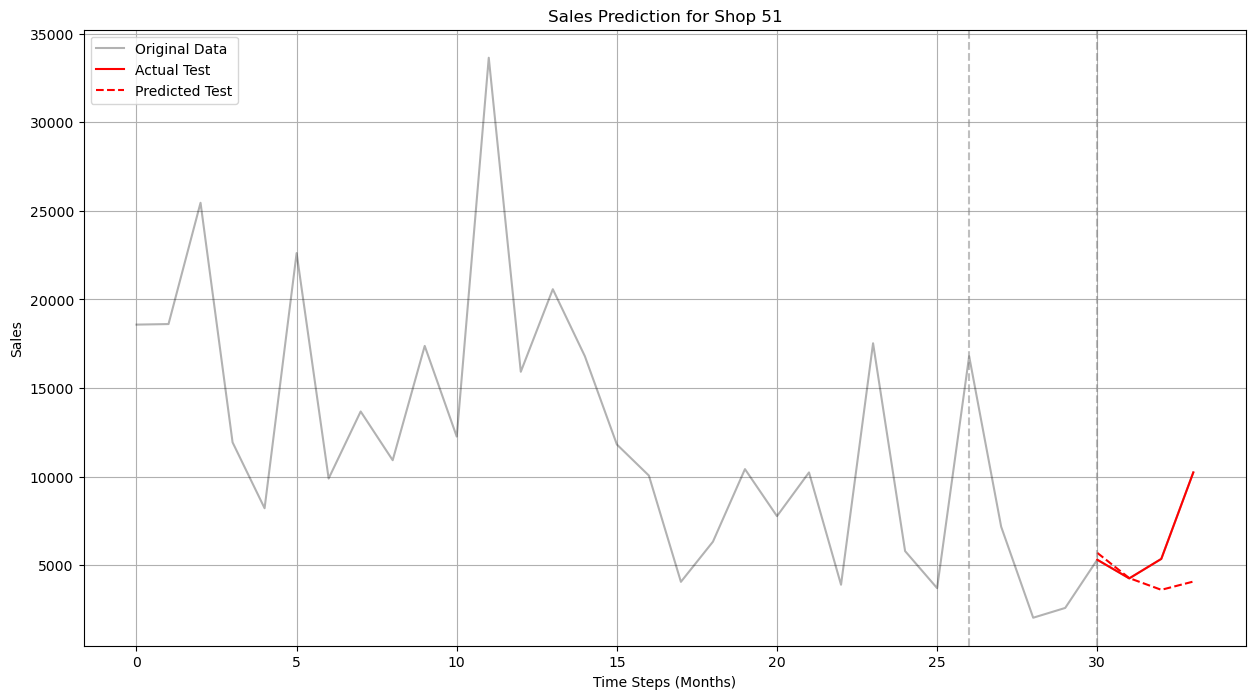


Shop 52:
MSE: 17760081.00
MAE: 3405.18


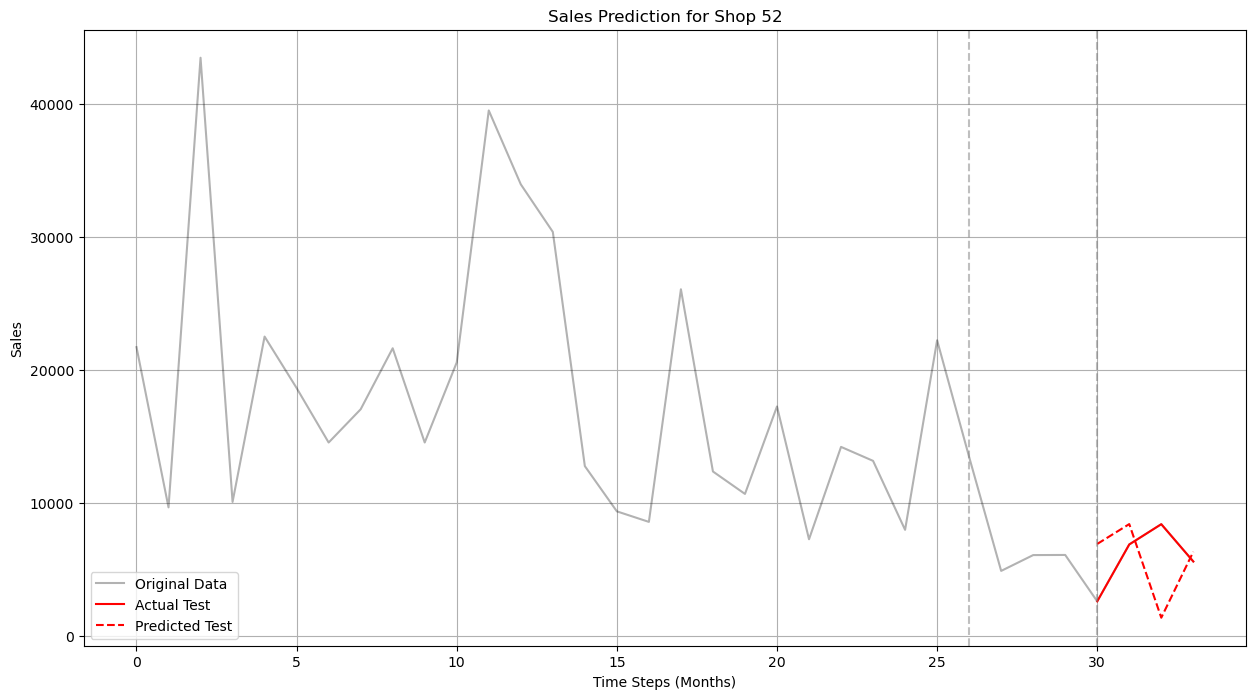


Shop 53:
MSE: 11432126.64
MAE: 3098.87


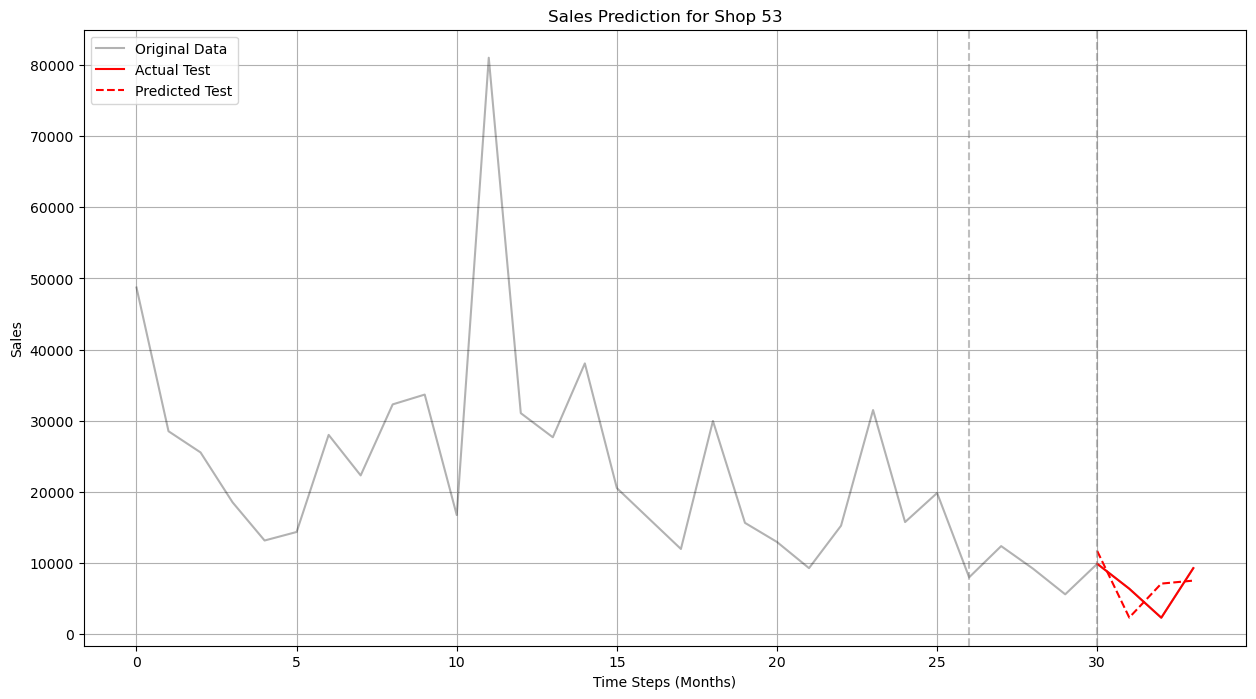


Shop 54:
MSE: 664225268.69
MAE: 23672.17


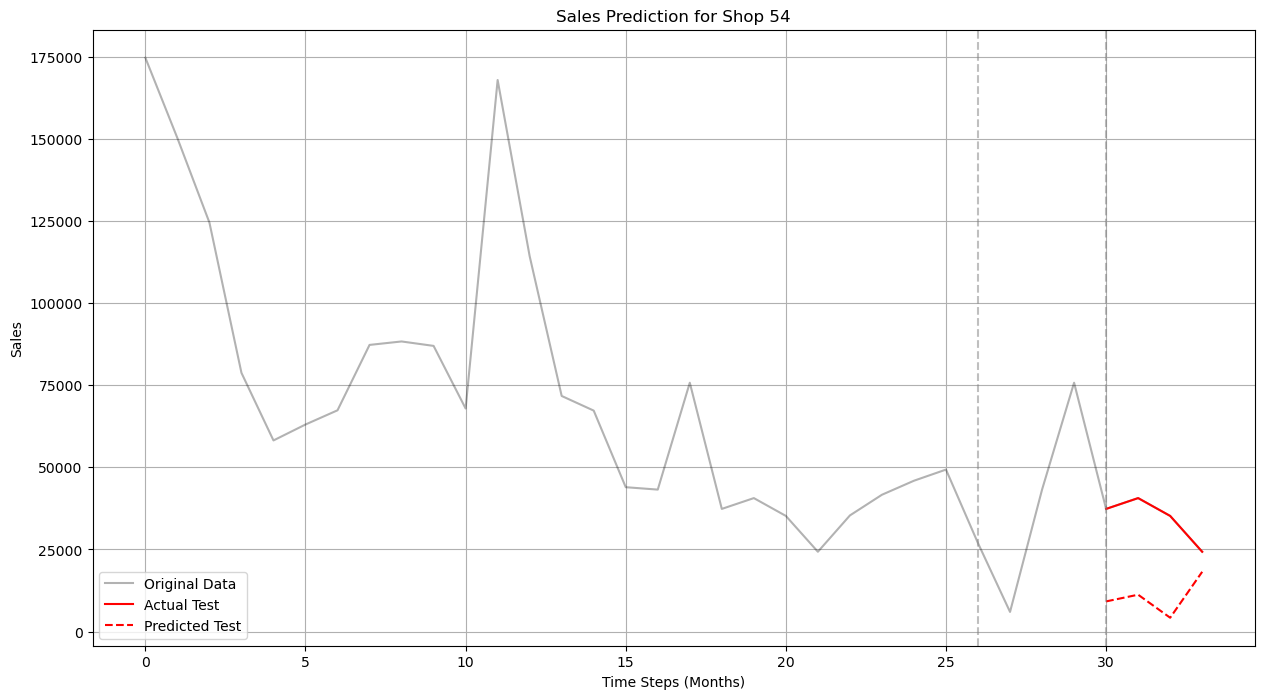


Shop 56:
MSE: 64061330.72
MAE: 7271.90


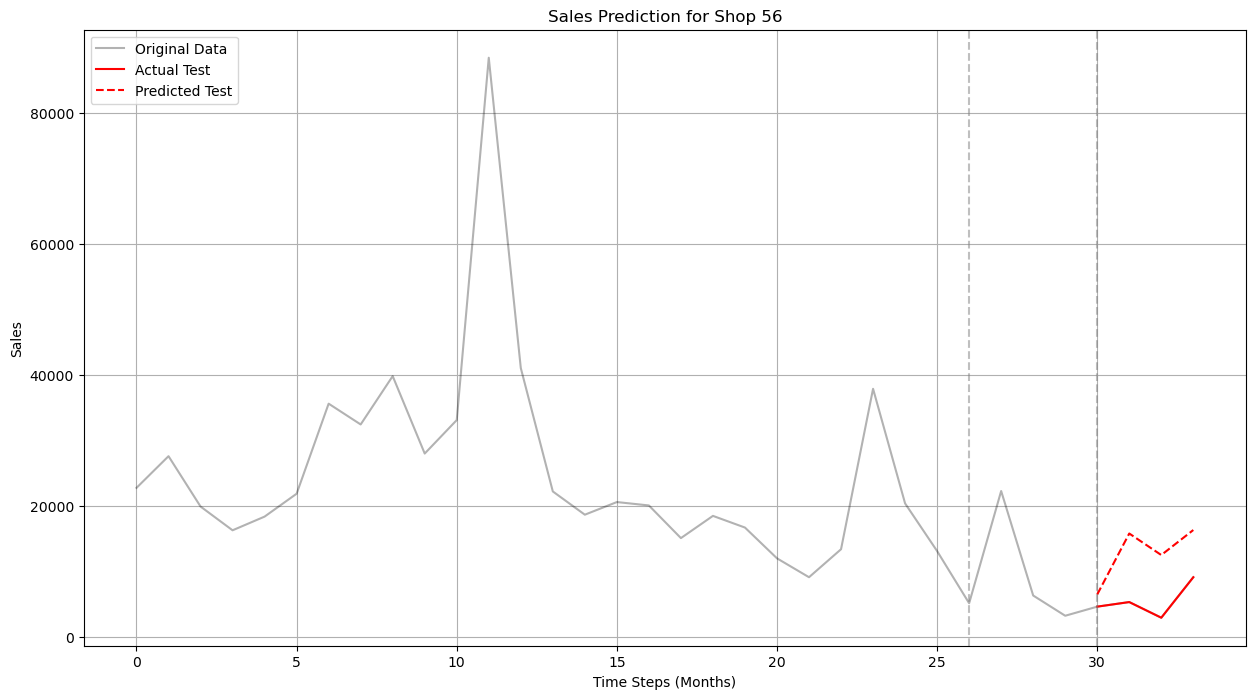


Shop 57:
MSE: 101539946.56
MAE: 9135.19


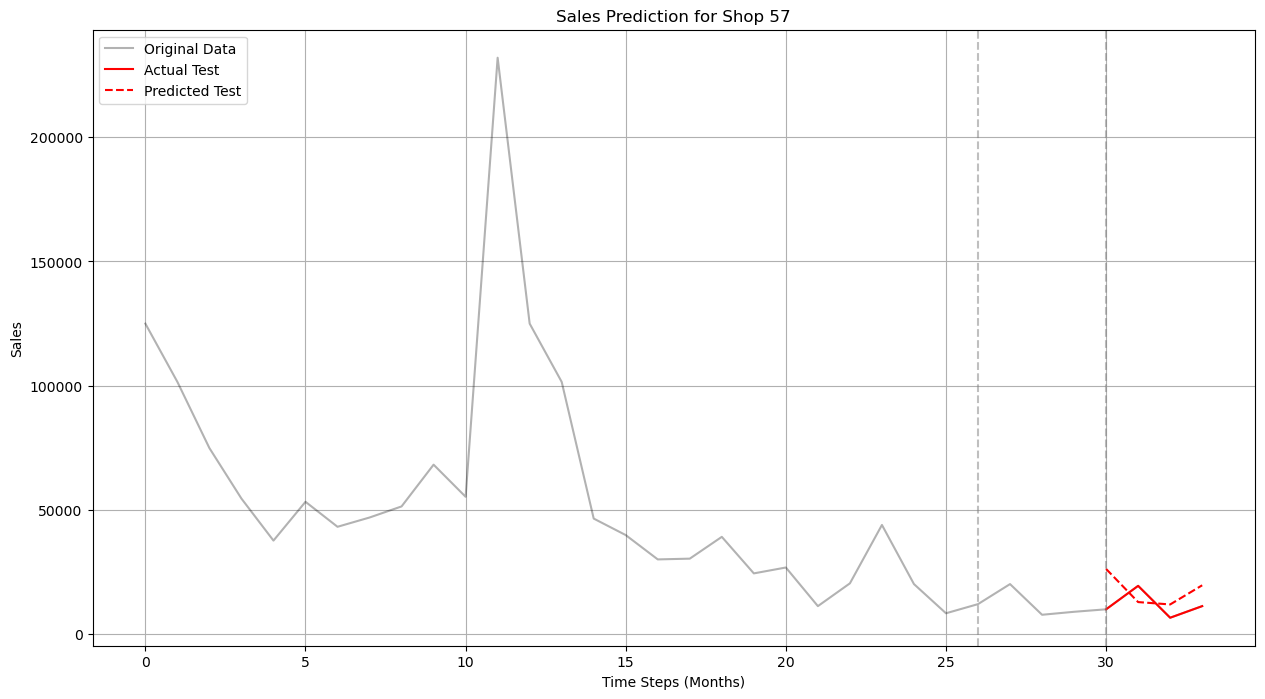


Shop 58:
MSE: 34843809.76
MAE: 5474.00


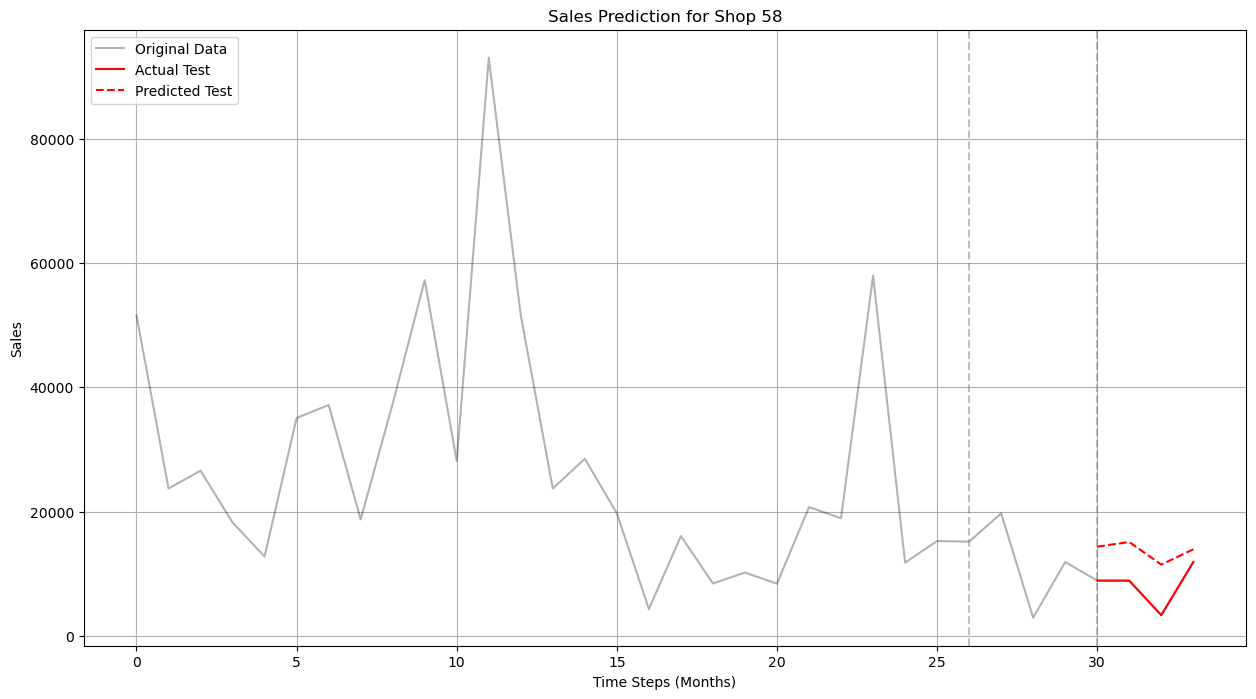


Shop 59:
MSE: 39692157.51
MAE: 4932.49


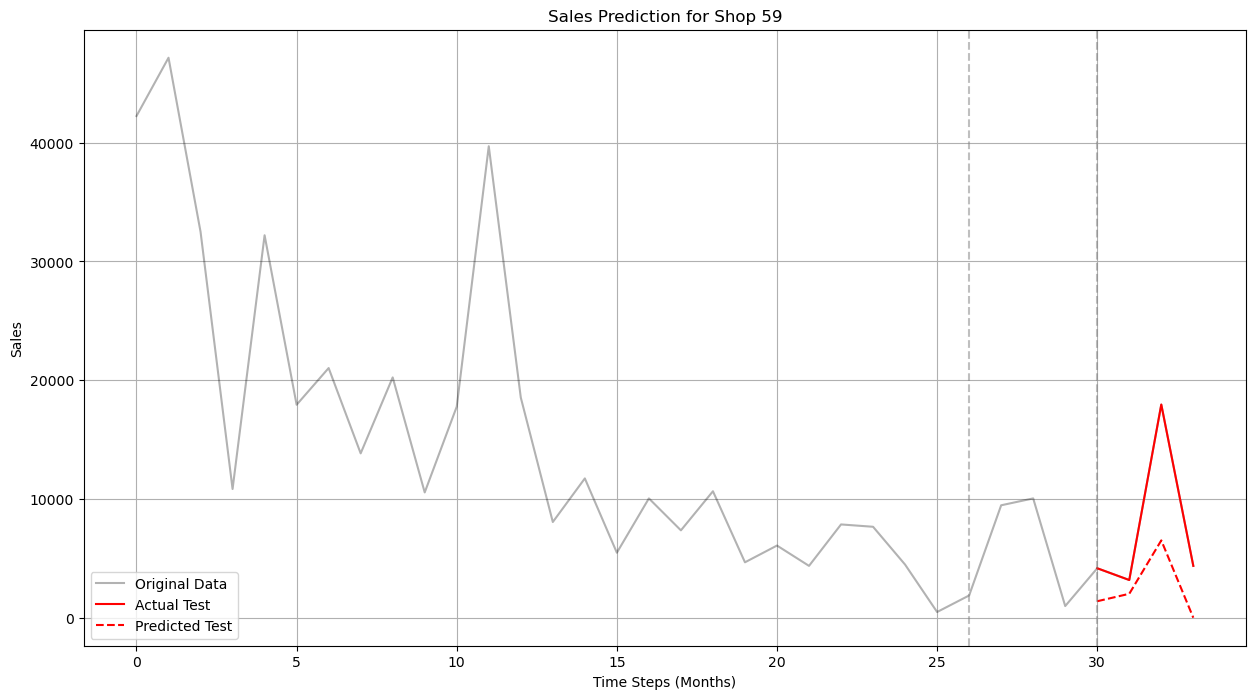


Overall Test Results:
MSE: 143487041.83
MAE: 7418.77
SMAPE: 70.63%


In [13]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import random
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

def create_sequences(data, seq_length, pred_length):
    """
    创建序列，data shape: [num_shops, time_steps]
    返回: sequences shape [num_sequences, num_shops, seq_length]
    """
    sequences = []
    targets = []
    
    for i in range(data.shape[1] - seq_length - pred_length + 1):
        seq = data[:, i:(i + seq_length)]
        target = data[:, (i + seq_length):(i + seq_length + pred_length)]
        sequences.append(seq)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)

class TCNPredictor(nn.Module):
    def __init__(self, num_shops, num_channels, kernel_size, dropout, pred_length):
        super(TCNPredictor, self).__init__()
        self.tcn = TemporalConvNet(num_shops, num_channels, kernel_size, dropout)
        # 修改linear层以适应多商店输出
        self.linear = nn.Linear(num_channels[-1], num_shops * pred_length)
        self.num_shops = num_shops
        self.pred_length = pred_length
        
    def forward(self, x):
        # x shape: [batch_size, num_shops, sequence_length]
        batch_size = x.size(0)
        
        # TCN处理
        x = self.tcn(x)  # [batch_size, channels, sequence_length]
        
        # 取最后一个时间步
        x = x[:, :, -1]  # [batch_size, channels]
        
        # 通过linear层
        x = self.linear(x)  # [batch_size, num_shops * pred_length]
        
        # 重塑输出为正确的维度
        x = x.view(batch_size, self.num_shops, self.pred_length)  # [batch_size, num_shops, pred_length]
        return x

def main():
    # Load data
    df = pd.read_csv('sales_full_bymonth.csv')
    
    # Actual shop IDs
    shop_ids = [2, 3, 4, 5, 6, 7, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22, 
                24, 25, 26, 27, 28, 29, 30, 31, 35, 37, 38, 39, 41, 42, 43, 
                44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59]
    
    # Parameters
    seq_length = 12
    pred_length = 4
    batch_size = 32
    num_epochs = 500
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 创建sales矩阵 [num_shops, time_steps]
    num_shops = len(shop_ids)
    sales_matrix = np.zeros((num_shops, 34))
    
    # 填充销售数据
    for idx, shop_id in enumerate(shop_ids):
        shop_data = df[df['shop_id'] == shop_id]['item_sales_month'].values
        sales_matrix[idx, :] = shop_data
    
    print("Sales matrix shape:", sales_matrix.shape)
    
    # 数据缩放
    scaler = MinMaxScaler()
    sales_matrix_scaled = scaler.fit_transform(sales_matrix.T).T
    
    # 划分数据集
    train_data = sales_matrix_scaled[:, :26]  # 0-26
    val_data = sales_matrix_scaled[:, 26:30]  # 27-30
    test_data = sales_matrix_scaled[:, 30:]   # 31-33
    
    print("Train data shape:", train_data.shape)
    print("Val data shape:", val_data.shape)
    print("Test data shape:", test_data.shape)
    
    # 创建训练序列
    train_sequences, train_targets = create_sequences(train_data, seq_length, pred_length)
    print("Train sequences shape:", train_sequences.shape)
    print("Train targets shape:", train_targets.shape)
    
    # 创建验证序列
    val_history = np.concatenate([train_data[:, -seq_length:], val_data], axis=1)
    print("Val history shape:", val_history.shape)
    val_sequences, val_targets = create_sequences(val_history, seq_length, pred_length)
    print("Val sequences shape:", val_sequences.shape)
    print("Val targets shape:", val_targets.shape)
    
    # 创建测试序列
    test_history = np.concatenate([val_data[:, -seq_length:], test_data], axis=1)
    print("Test history shape:", test_history.shape)
    
    # 正确重塑测试序列
    test_sequences = test_history[:, :seq_length]  # 取最后12个时间步
    print("Test sequences before reshape:", test_sequences.shape)
    test_sequences = np.expand_dims(test_sequences, axis=0)  # 添加batch维度
    print("Test sequences after reshape:", test_sequences.shape)
    
    # 创建数据集
    train_dataset = TimeSeriesDataset(
        torch.FloatTensor(train_sequences),
        torch.FloatTensor(train_targets)
    )
    val_dataset = TimeSeriesDataset(
        torch.FloatTensor(val_sequences),
        torch.FloatTensor(val_targets)
    )    
    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # 初始化模型
    num_channels = [32, 64, 128, 256]
    model = TCNPredictor(
        num_shops=num_shops,
        num_channels=num_channels,
        kernel_size=3,
        dropout=0.2,
        pred_length=pred_length
    ).to(device)
    

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # 训练模型
    best_val_loss = float('inf')
    patience = 5
    counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        total_train_loss = 0
        for sequences, targets in train_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            loss.backward()
            # 插入梯度监控代码
            for param in model.parameters():
                if param.grad is not None:  # 检查是否存在梯度
                    print(f"Gradient max abs value: {param.grad.abs().max().item()}") 
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # 验证阶段
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences = sequences.to(device)
                targets = targets.to(device)
                
                outputs = model(sequences)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        
        # 早停
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            torch.save(model.state_dict(), 'tcn_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break
    
    # 加载最佳模型进行预测
    model.load_state_dict(torch.load('tcn_model.pth'))
    model.eval()
    
    # 预测测试集
    with torch.no_grad():
        test_sequences_tensor = torch.FloatTensor(test_sequences).to(device)
        test_predictions = model(test_sequences_tensor)
        test_predictions = test_predictions.cpu().numpy().squeeze()
    
    # 转换回原始比例
    test_predictions_original = scaler.inverse_transform(test_predictions.T).T
    test_actual_original = scaler.inverse_transform(test_data.T).T
    
    # 计算并显示测试集结果
    print("\nTest Set Results:")
    for i, shop_id in enumerate(shop_ids):
        mse = np.mean((test_actual_original[i] - test_predictions_original[i]) ** 2)
        mae = np.mean(np.abs(test_actual_original[i] - test_predictions_original[i]))
        print(f"\nShop {shop_id}:")
        print(f"MSE: {mse:.2f}")
        print(f"MAE: {mae:.2f}")
        
        # 绘制预测结果
        plt.figure(figsize=(15, 8))
        plt.plot(range(34), sales_matrix[i], 'k-', label='Original Data', alpha=0.3)
        plt.plot(range(30, 34), test_actual_original[i], 'r-', label='Actual Test')
        plt.plot(range(30, 34), test_predictions_original[i], 'r--', label='Predicted Test')
        
        plt.axvline(x=26, color='gray', linestyle='--', alpha=0.5)
        plt.axvline(x=30, color='gray', linestyle='--', alpha=0.5)
        
        plt.title(f'Sales Prediction for Shop {shop_id}')
        plt.xlabel('Time Steps (Months)')
        plt.ylabel('Sales')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # 计算整体性能
    overall_mse = np.mean((test_actual_original - test_predictions_original) ** 2)
    overall_mae = np.mean(np.abs(test_actual_original - test_predictions_original))
    overall_smape = smape(test_actual_original, test_predictions_original)

    print("\nOverall Test Results:")
    print(f"MSE: {overall_mse:.2f}")
    print(f"MAE: {overall_mae:.2f}")
    print(f"SMAPE: {overall_smape:.2f}%")


if __name__ == '__main__':
    seed = 23
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # 为了让CUDA的卷积等操作可复现，需设置如下
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    main()